# Bollinger Band Strategy
Author: TraderPy

Youtube: https://www.youtube.com/channel/UC9xYCyyR_G3LIuJ_LlTiEVQ/featured

Website: https://traderpy.com/

## Disclaimer
Trading the financial markets imposes a risk of financial loss. TraderPy is not responsible for any financial losses that viewers suffer. Content is educational only and does not serve as financial advice. Information or material is provided ‘as is’ without any warranty. 

Past trading results do not indicate future performance. Strategies that worked in the past may not reflect the same results in the future.

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

In [ ]:
# Connecting to IC Markets MetaTrader5 Account
mt5.initialize()

In [ ]:
# Getting OHLC Data from MT5 GBPUSD
bars = mt5.copy_rates_range("GBPUSD", mt5.TIMEFRAME_D1, 
                            datetime(2020, 1, 1), datetime.now())

bars

In [ ]:
# Convert bars to DataFrame
df = pd.DataFrame(bars)
df

In [ ]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')
df

In [ ]:
# plotting close prices
fig = px.line(df, x='time', y='close')
fig

In [ ]:
# calculate bollinger bands

# calculate sma
df['sma'] = df['close'].rolling(20).mean()

# calculate standard deviation
df['sd'] = df['close'].rolling(20).std()

# calculate lower band
df['lb'] = df['sma'] - 2 * df['sd']

# calculate upper band
df['ub'] = df['sma'] + 2 * df['sd']

df.dropna(inplace=True)
df

In [ ]:
# plotting close prices with bollinger bands
fig = px.line(df, x='time', y=['close', 'sma', 'lb', 'ub'])
fig

In [ ]:
# find signals

def find_signal(close, lower_band, upper_band):
    if close < lower_band:
        return 'buy'
    elif close > upper_band:
        return 'sell'
    
    
df['signal'] = np.vectorize(find_signal)(df['close'], df['lb'], df['ub'])

df

In [ ]:
# creating backtest and position classes

class Position:
    def __init__(self, open_datetime, open_price, order_type, volume, sl, tp):
        self.open_datetime = open_datetime
        self.open_price = open_price
        self.order_type = order_type
        self.volume = volume
        self.sl = sl
        self.tp = tp
        self.close_datetime = None
        self.close_price = None
        self.profit = None
        self.status = 'open'
        
    def close_position(self, close_datetime, close_price):
        self.close_datetime = close_datetime
        self.close_price = close_price
        self.profit = (self.close_price - self.open_price) * self.volume if self.order_type == 'buy' \
                                                                        else (self.open_price - self.close_price) * self.volume
        self.status = 'closed'
        
    def _asdict(self):
        return {
            'open_datetime': self.open_datetime,
            'open_price': self.open_price,
            'order_type': self.order_type,
            'volume': self.volume,
            'sl': self.sl,
            'tp': self.tp,
            'close_datetime': self.close_datetime,
            'close_price': self.close_price,
            'profit': self.profit,
            'status': self.status,
        }
        
        
class Strategy:
    def __init__(self, df, starting_balance, volume):
        self.starting_balance = starting_balance
        self.volume = volume
        self.positions = []
        self.data = df
        
    def get_positions_df(self):
        df = pd.DataFrame([position._asdict() for position in self.positions])
        df['pnl'] = df['profit'].cumsum() + self.starting_balance
        return df
        
    def add_position(self, position):
        self.positions.append(position)
        
    def trading_allowed(self):
        for pos in self.positions:
            if pos.status == 'open':
                return False
        
        return True
        
    def run(self):
        for i, data in self.data.iterrows():
            
            if data.signal == 'buy' and self.trading_allowed():
                sl = data.close - 3 * data.sd
                tp = data.close + 2 * data.sd
                self.add_position(Position(data.time, data.close, data.signal, self.volume, sl, tp))
                
            elif data.signal == 'sell' and self.trading_allowed():
                sl = data.close + 3 * data.sd
                tp = data.close - 2 * data.sd
                self.add_position(Position(data.time, data.close, data.signal, self.volume, sl, tp))
                
            for pos in self.positions:
                if pos.status == 'open':
                    if (pos.sl >= data.close and pos.order_type == 'buy'):
                        pos.close_position(data.time, pos.sl)
                    elif (pos.sl <= data.close and pos.order_type == 'sell'):
                        pos.close_position(data.time, pos.sl)
                    elif (pos.tp <= data.close and pos.order_type == 'buy'):
                        pos.close_position(data.time, pos.tp)
                    elif (pos.tp >= data.close and pos.order_type == 'sell'):
                        pos.close_position(data.time, pos.tp)
                        
        return self.get_positions_df()



In [ ]:
# run the backtest
bollinger_strategy = Strategy(df, 10000, 100000)
result = bollinger_strategy.run()

result

In [ ]:
# plotting close prices with bollinger bands
fig = px.line(df, x='time', y=['close', 'sma', 'lb', 'ub'])

# adding trades to plots
for i, position in result.iterrows():
    if position.status == 'closed':
        fig.add_shape(type="line",
            x0=position.open_datetime, y0=position.open_price, x1=position.close_datetime, y1=position.close_price,
            line=dict(
                color="green" if position.profit >= 0 else "red",
                width=3)
            )
fig

In [ ]:
# visualizing the results of the backtest
px.line(result, x='close_datetime', y='pnl')

# My version of the strategy

Making the strategy my own before I integrate it into the algo bot

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(r'c:\Users\Windows User\My_folder\Finance_project')  # Add the folder, not the file

try:
    from trading_functions import unified_bayesian_gp_forecast
    print("✅ Successfully imported unified_bayesian_gp_forecast")
except ModuleNotFoundError as e:
    print(f"❌ ModuleNotFoundError: {e}. Please ensure trading_functions.py is in the correct folder.")

✅ Successfully imported unified_bayesian_gp_forecast


🔮 RUNNING BAYESIAN GP FORECAST FOR ENTIRE PORTFOLIO

🚀 Processing CZOOF...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for czoof...
🟠 Running Gaussian Process for czoof...


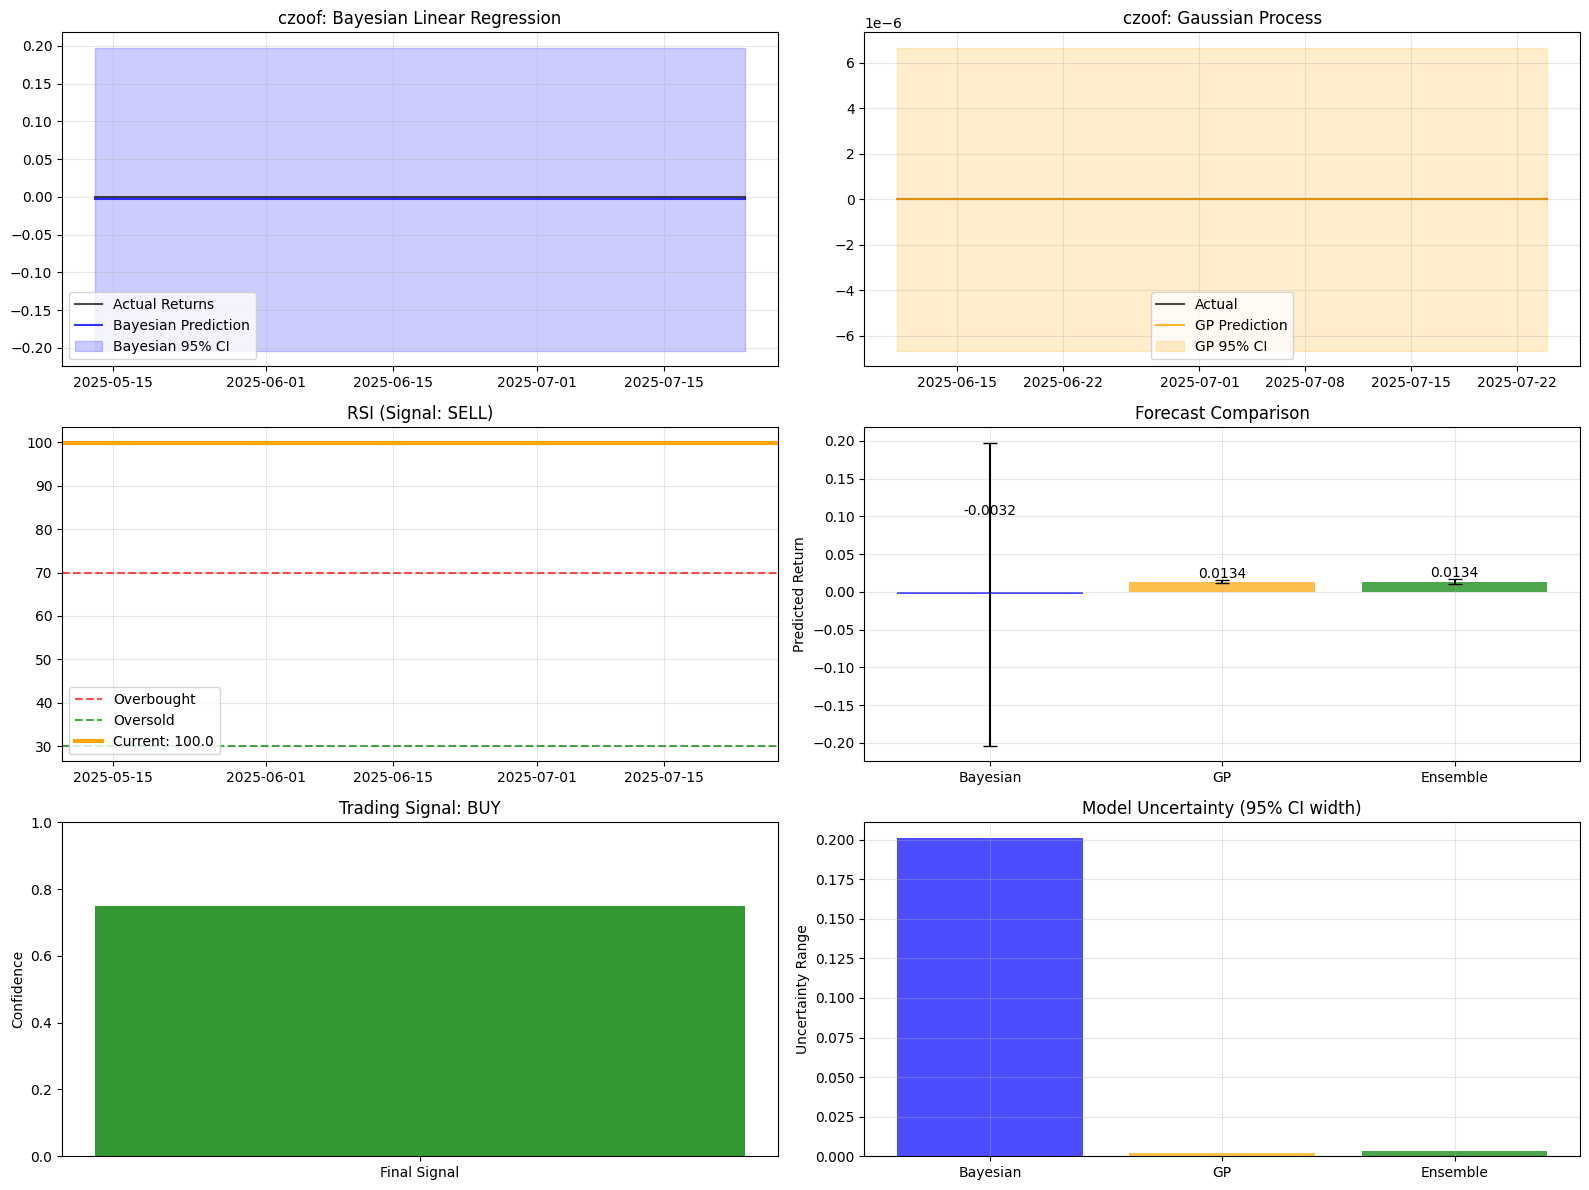


📊 czoof - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: -0.0032 ± 0.2009
🟠 GP Forecast:       0.0134 ± 0.0019
🟢 Ensemble Forecast: 0.0134 ± 0.0033
📈 RSI Signal:        SELL (RSI: 100.0)
🎯 Final Signal:      BUY (Confidence: 75.0%)
💰 Recommendation:    BUY
✅ CZOOF analysis complete!

🚀 Processing FCNVX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for FCNVX
⚠️ FCNVX analysis failed - insufficient data

🚀 Processing FDIG...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for fdig...
🟠 Running Gaussian Process for fdig...


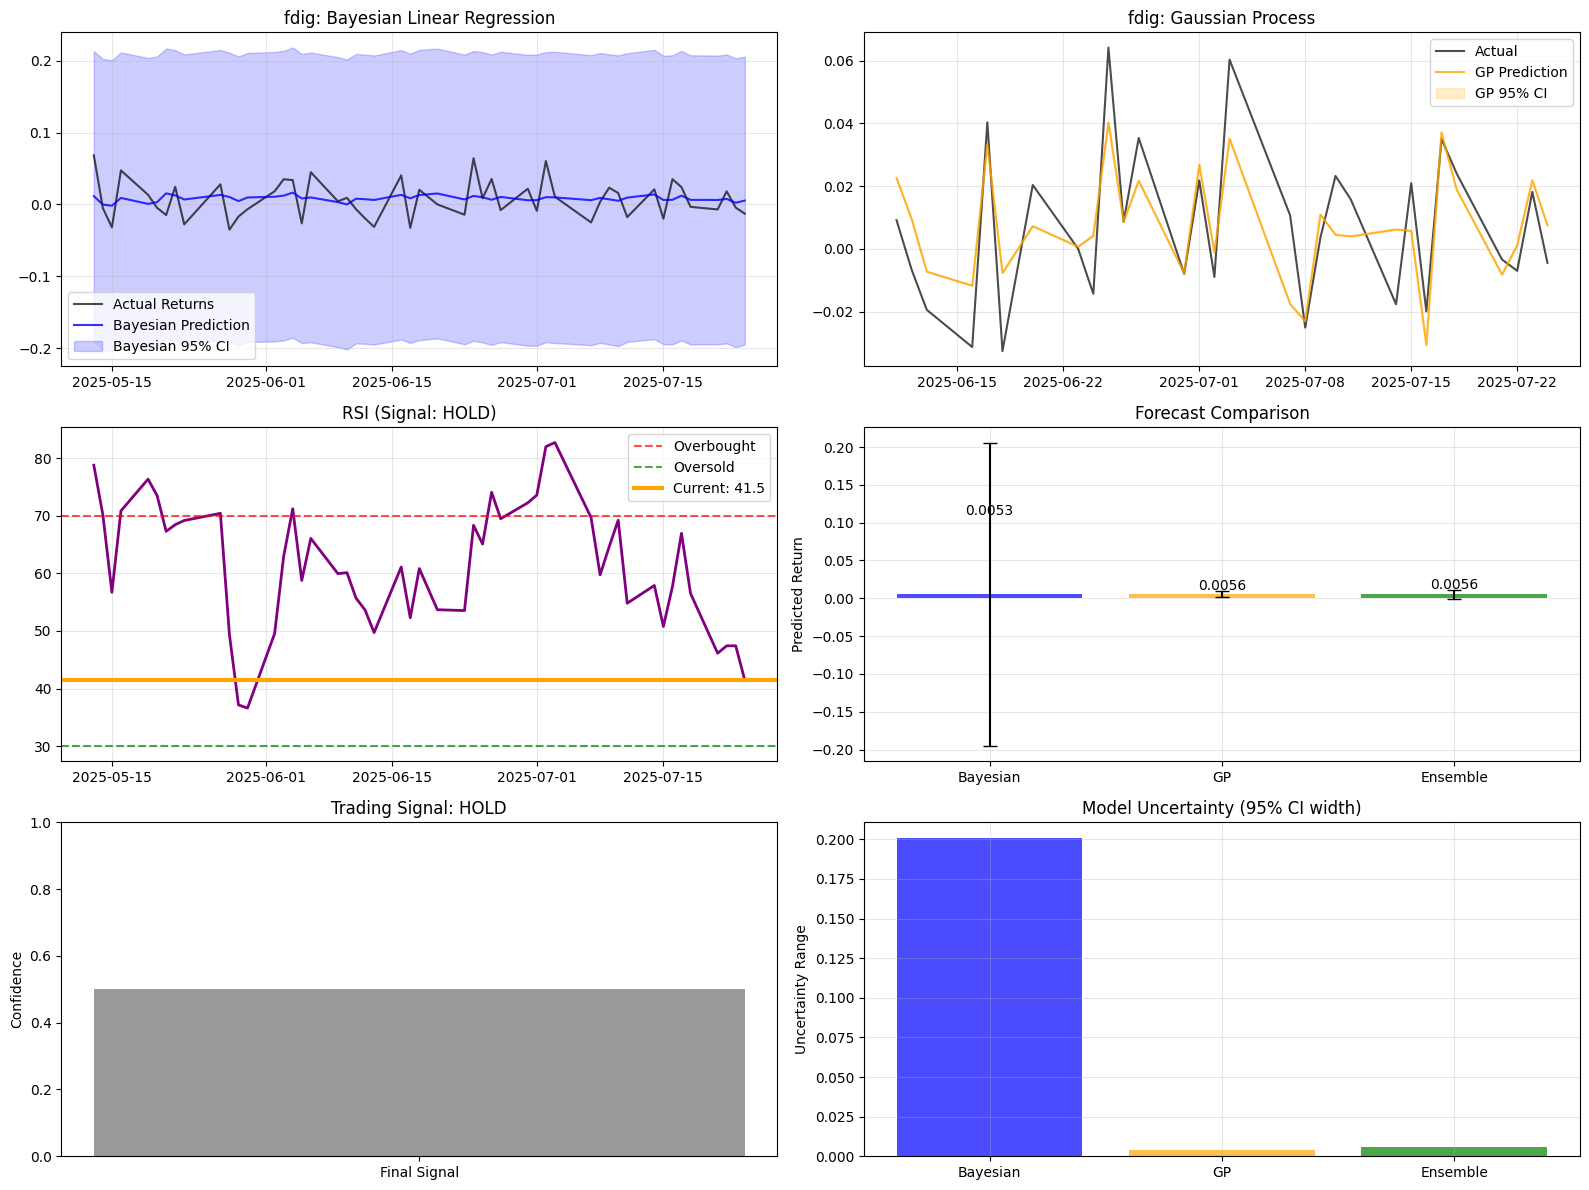

[*********************100%***********************]  1 of 1 completed


📊 fdig - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0053 ± 0.2007
🟠 GP Forecast:       0.0056 ± 0.0040
🟢 Ensemble Forecast: 0.0056 ± 0.0060
📈 RSI Signal:        HOLD (RSI: 41.5)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ FDIG analysis complete!

🚀 Processing FDKVX...


⚠️ Not enough usable data after cleaning for fdkvx
⚠️ FDKVX analysis failed - insufficient data

🚀 Processing FEDDX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for feddx
⚠️ FEDDX analysis failed - insufficient data

🚀 Processing FFRHX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for ffrhx
⚠️ FFRHX analysis failed - insufficient data

🚀 Processing FIFNX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for fifnx
⚠️ FIFNX analysis failed - insufficient data

🚀 Processing FITLX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for fitlx
⚠️ FITLX analysis failed - insufficient data

🚀 Processing FLOWX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for flowx
⚠️ FLOWX analysis failed - insufficient data

🚀 Processing FSENX...


[*********************100%***********************]  1 of 1 completed


⚠️ Not enough usable data after cleaning for fsenx
⚠️ FSENX analysis failed - insufficient data

🚀 Processing LION...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for LION...
🟠 Running Gaussian Process for LION...


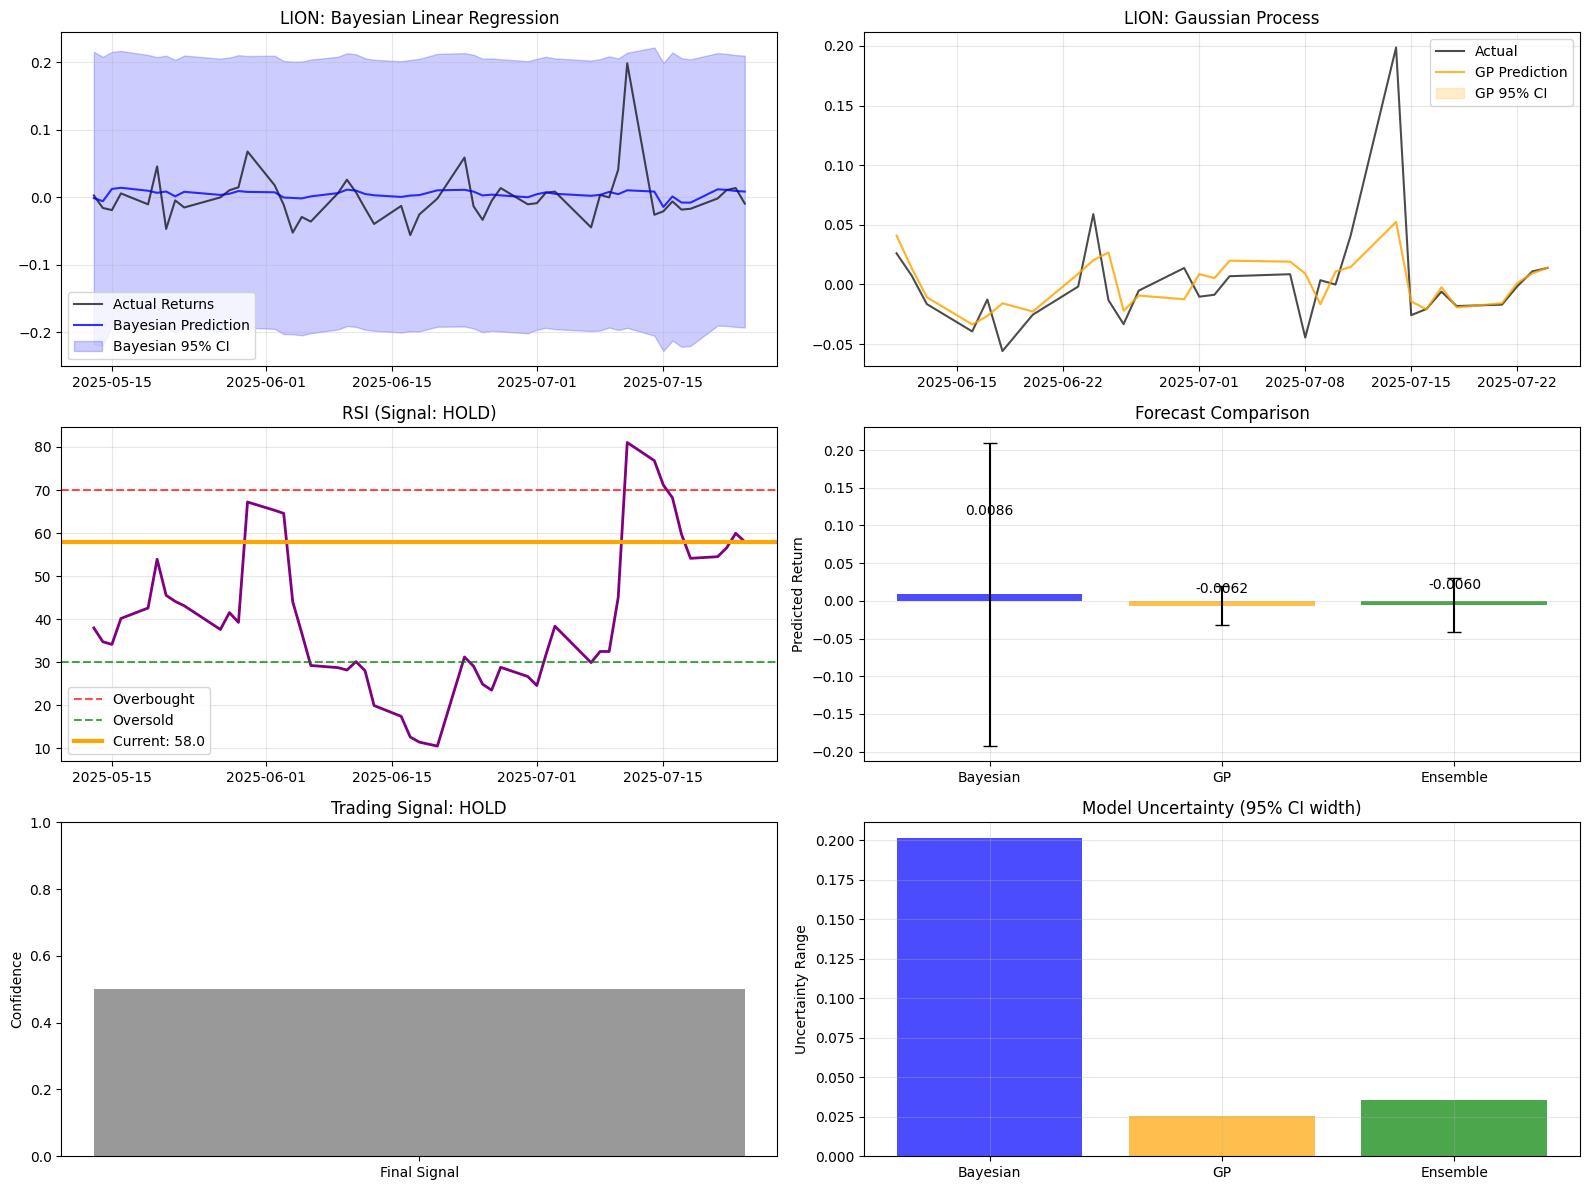


📊 LION - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0086 ± 0.2013
🟠 GP Forecast:       -0.0062 ± 0.0254
🟢 Ensemble Forecast: -0.0060 ± 0.0358
📈 RSI Signal:        HOLD (RSI: 58.0)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ LION analysis complete!

🚀 Processing OLLI...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for OLLI...
🟠 Running Gaussian Process for OLLI...


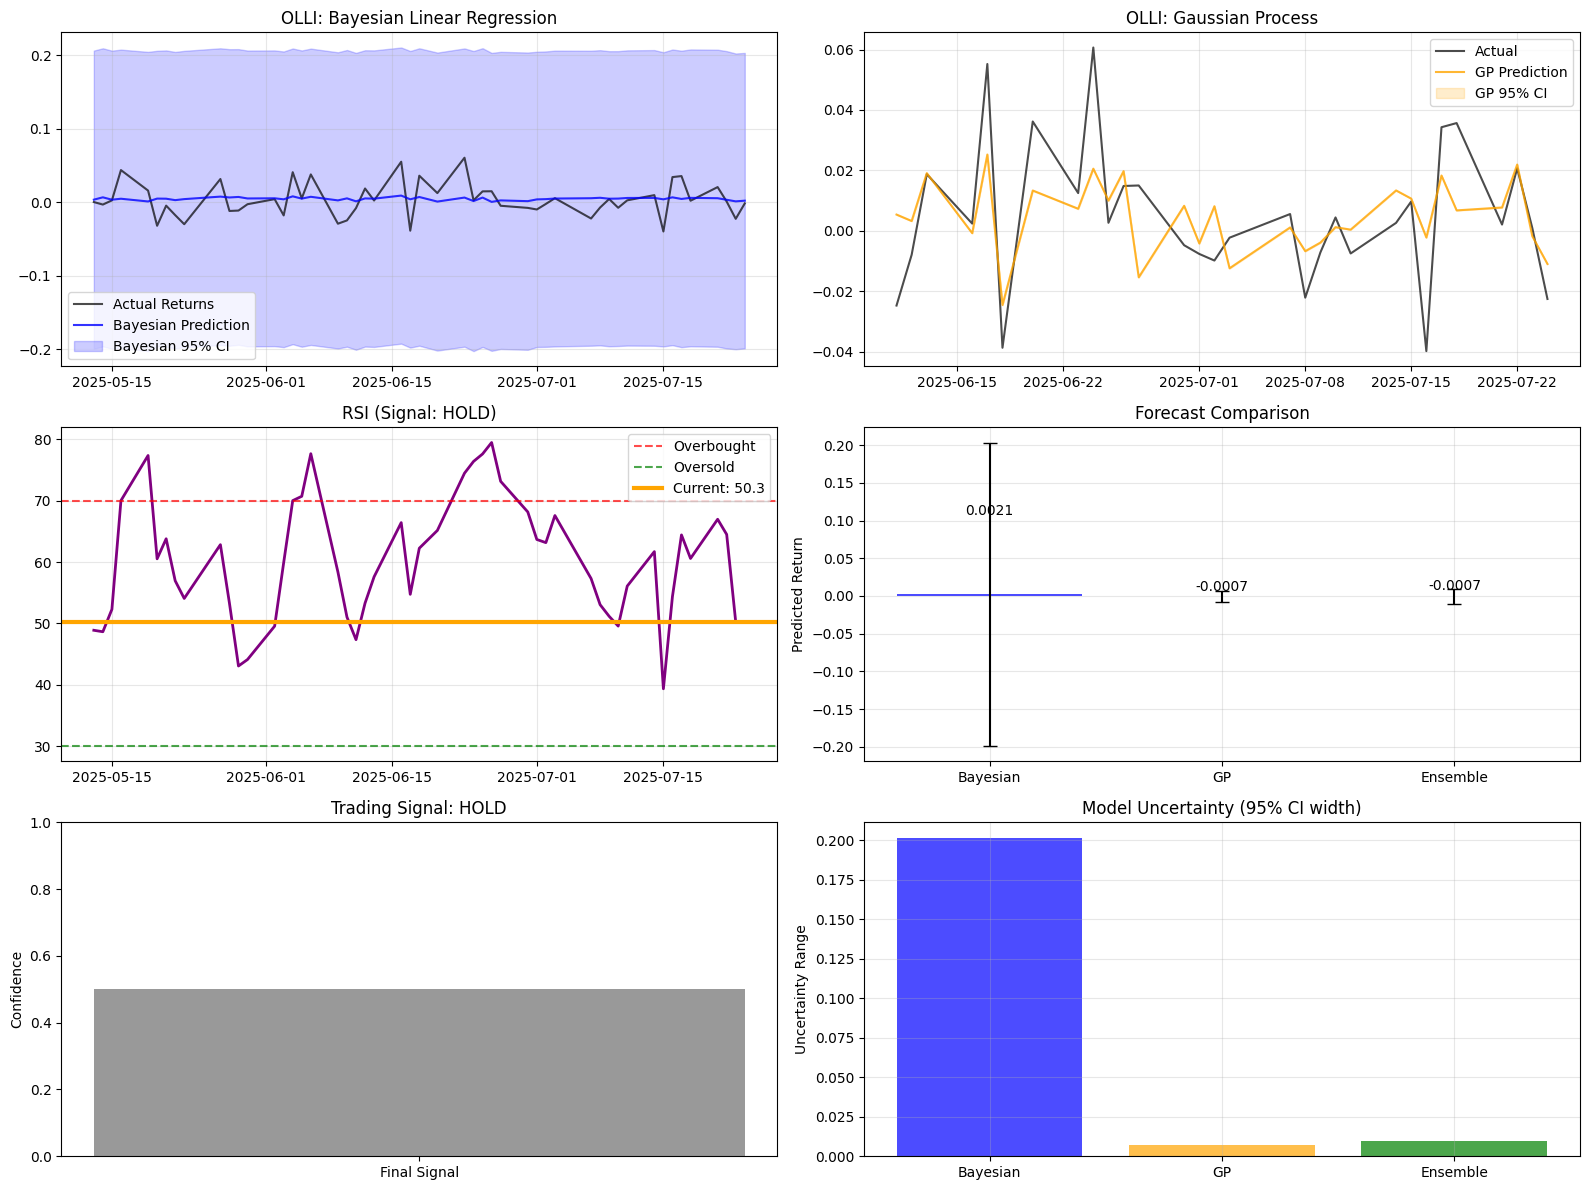


📊 OLLI - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0021 ± 0.2013
🟠 GP Forecast:       -0.0007 ± 0.0069
🟢 Ensemble Forecast: -0.0007 ± 0.0100
📈 RSI Signal:        HOLD (RSI: 50.3)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ OLLI analysis complete!

🚀 Processing UNP...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for UNP...
🟠 Running Gaussian Process for UNP...


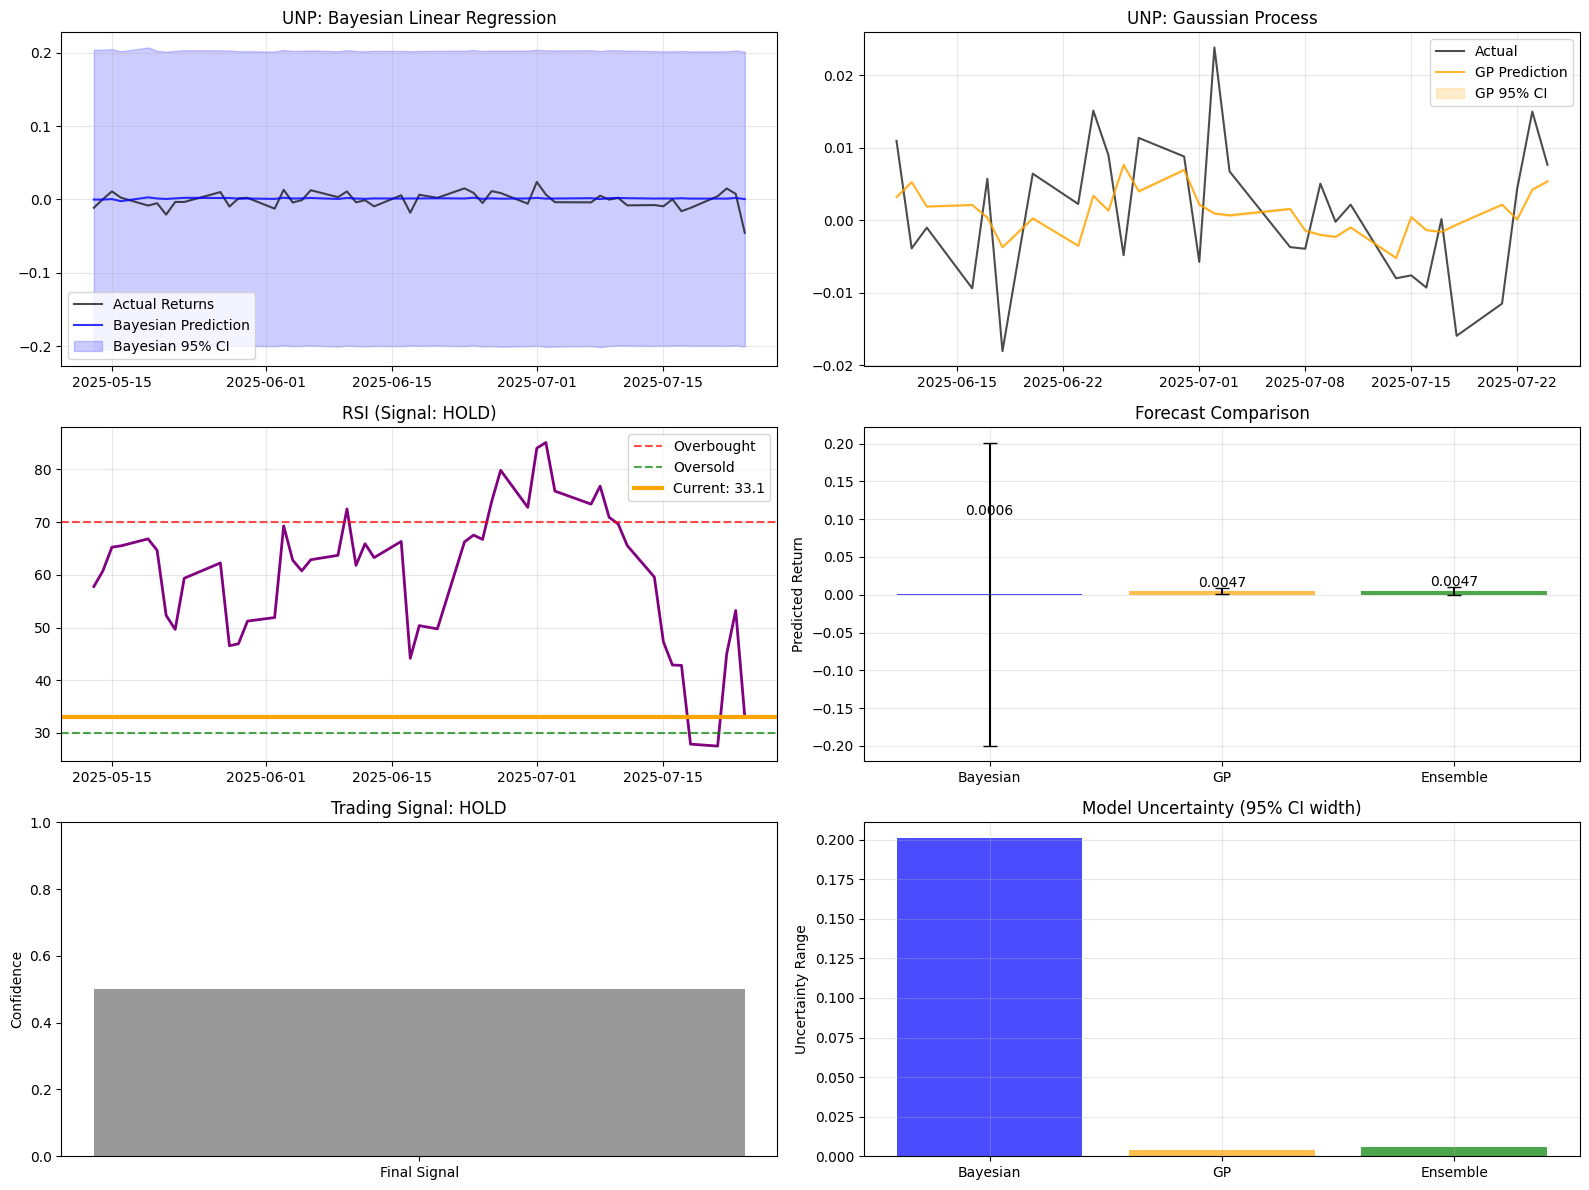


📊 UNP - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0006 ± 0.2009
🟠 GP Forecast:       0.0047 ± 0.0037
🟢 Ensemble Forecast: 0.0047 ± 0.0056
📈 RSI Signal:        HOLD (RSI: 33.1)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ UNP analysis complete!

🚀 Processing VZ...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for VZ...
🟠 Running Gaussian Process for VZ...


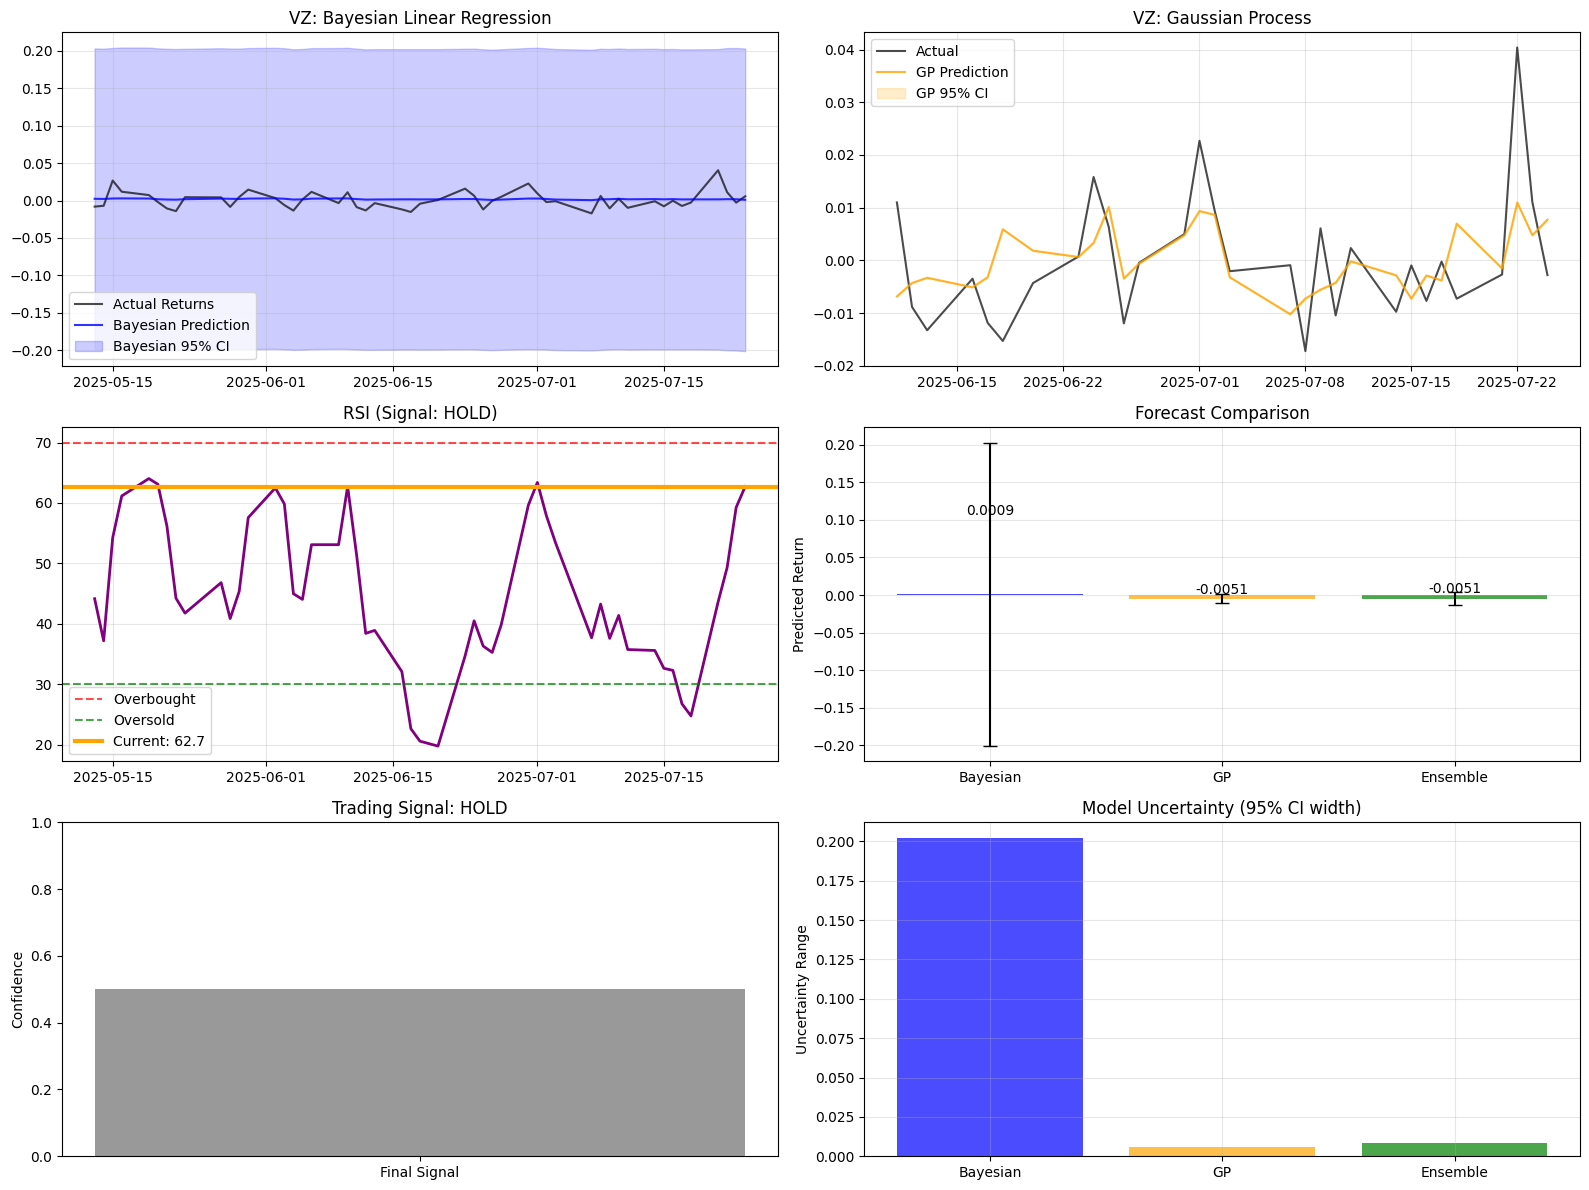

[*********************100%***********************]  1 of 1 completed


📊 VZ - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0009 ± 0.2020
🟠 GP Forecast:       -0.0051 ± 0.0058
🟢 Ensemble Forecast: -0.0051 ± 0.0085
📈 RSI Signal:        HOLD (RSI: 62.7)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ VZ analysis complete!

🚀 Processing WPP...



🔵 Running Bayesian Linear Regression for WPP...
🟠 Running Gaussian Process for WPP...


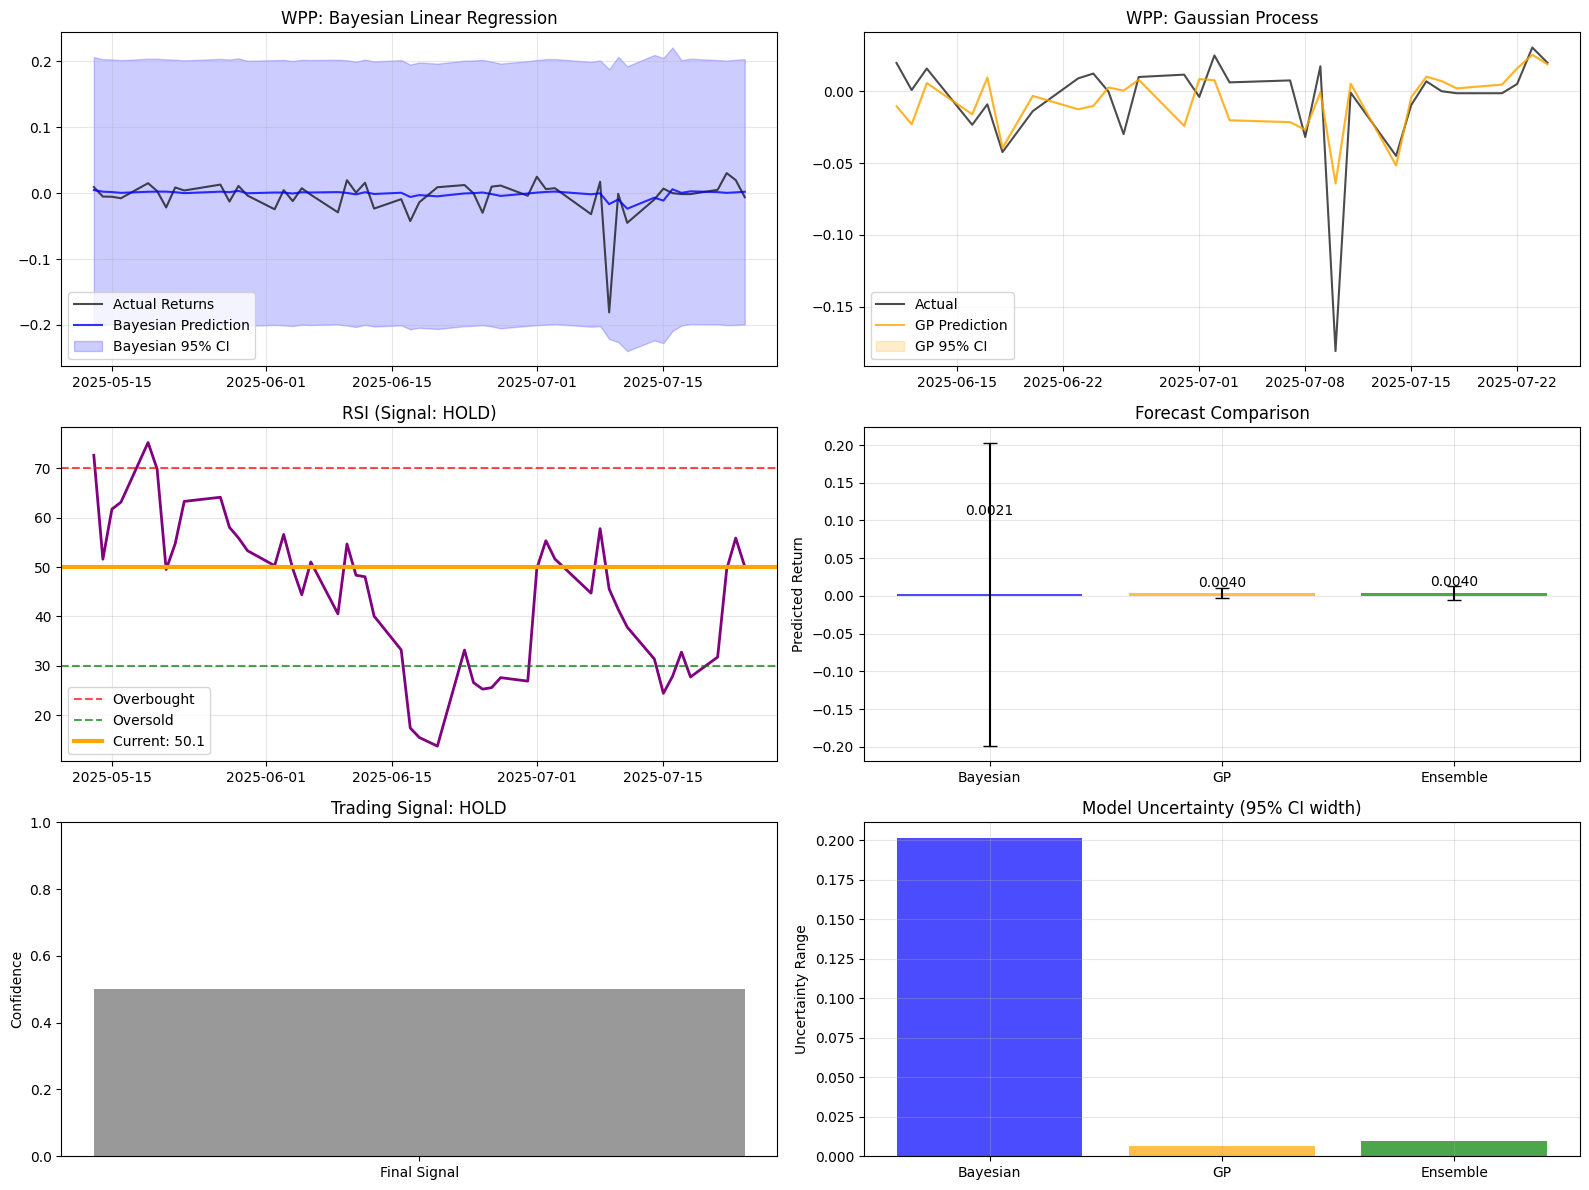


📊 WPP - Unified Forecast Summary (2025-07-24)
🔵 Bayesian Forecast: 0.0021 ± 0.2012
🟠 GP Forecast:       0.0040 ± 0.0067
🟢 Ensemble Forecast: 0.0040 ± 0.0097
📈 RSI Signal:        HOLD (RSI: 50.1)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✅ WPP analysis complete!

🎯 PORTFOLIO FORECAST SUMMARY
Ticker   Signal       Confidence Forecast     RSI   
----------------------------------------------------------------------
CZOOF    BUY          0.75       0.0134       100.0 
FDIG     HOLD         0.50       0.0056       41.5  
LION     HOLD         0.50       -0.0060      58.0  
OLLI     HOLD         0.50       -0.0007      50.3  
UNP      HOLD         0.50       0.0047       33.1  
VZ       HOLD         0.50       -0.0051      62.7  
WPP      HOLD         0.50       0.0040       50.1  
----------------------------------------------------------------------
📊 PORTFOLIO SIGNALS: 🟢 1 BUY | 🔴 0 SELL | 🟡 6 HOLD
🎯 Total Analyzed: 7/15 stocks


In [2]:
portfolio = {
    'czoof': 0.2,
    'FCNVX': 0.995,
    'fdig': 0.925,
    'fdkvx': 0.862,
    'feddx': 0.961,
    'ffrhx': 3.247,
    'fifnx': 0.969,
    'fitlx': 1.151,
    'flowx': 0.838,
    'fsenx': 0.326,
    'LION': 2,
    'OLLI': 0.175,
    'UNP': 0.1,
    'VZ': 0.5,
    'WPP': 0.3
}
ticker = list(portfolio.keys())

print("🔮 RUNNING BAYESIAN GP FORECAST FOR ENTIRE PORTFOLIO")
print("="*60)

portfolio_forecasts = {}

for individual_ticker in ticker:
    print(f"\n🚀 Processing {individual_ticker.upper()}...")
    try:
        result = unified_bayesian_gp_forecast(individual_ticker)  # Single ticker, not list
        if result:
            portfolio_forecasts[individual_ticker] = result
            print(f"✅ {individual_ticker.upper()} analysis complete!")
        else:
            print(f"⚠️ {individual_ticker.upper()} analysis failed - insufficient data")
    except Exception as e:
        print(f"❌ Error analyzing {individual_ticker.upper()}: {str(e)}")
        portfolio_forecasts[individual_ticker] = {"error": str(e)}

# Display portfolio-wide results
print("\n🎯 PORTFOLIO FORECAST SUMMARY")
print("="*70)
print(f"{'Ticker':<8} {'Signal':<12} {'Confidence':<10} {'Forecast':<12} {'RSI':<6}")
print("-"*70)

buy_signals = 0
sell_signals = 0
hold_signals = 0

for ticker_sym, forecast_data in portfolio_forecasts.items():
    if 'error' not in forecast_data:
        signal = forecast_data['final_signal']
        confidence = forecast_data['confidence']
        forecast = forecast_data['ensemble']['forecast']
        rsi = forecast_data['rsi']['value']
        
        print(f"{ticker_sym.upper():<8} {signal:<12} {confidence:<10.2f} {forecast:<12.4f} {rsi:<6.1f}")
        
        if 'BUY' in signal:
            buy_signals += 1
        elif 'SELL' in signal:
            sell_signals += 1
        else:
            hold_signals += 1
    else:
        print(f"{ticker_sym.upper():<8} ERROR: {forecast_data['error']}")

print("-"*70)
print(f"📊 PORTFOLIO SIGNALS: 🟢 {buy_signals} BUY | 🔴 {sell_signals} SELL | 🟡 {hold_signals} HOLD")
print(f"🎯 Total Analyzed: {len([f for f in portfolio_forecasts.values() if 'error' not in f])}/{len(ticker)} stocks")
print("="*70)

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(r'c:\\Users\\Windows User\\My_folder\\Finance_project')

try:
    from trading_functions import unified_bayesian_gp_forecast
    print("✅ Successfully imported unified_bayesian_gp_forecast")
except ModuleNotFoundError as e:
    print(f"❌ ModuleNotFoundError: {e}. Please ensure trading_functions.py is in the correct folder.")

portfolio = {
    'czoof': 0.2,
    'FCNVX': 0.995,
    'fdig': 0.925,
    'fdkvx': 0.862,
    'feddx': 0.961,
    'ffrhx': 3.247,
    'fifnx': 0.969,
    'fitlx': 1.151,
    'flowx': 0.838,
    'fsenx': 0.326,
    'LION': 2,
    'OLLI': 0.175,
    'UNP': 0.1,
    'VZ': 0.5,
    'WPP': 0.3
}
ticker_list = list(portfolio.keys())

# --- Adapted Bollinger Bands Strategy for Portfolio ---
class Position:
    def __init__(self, open_datetime, open_price, order_type, volume, sl, tp):
        self.open_datetime = open_datetime
        self.open_price = open_price
        self.order_type = order_type
        self.volume = volume
        self.sl = sl
        self.tp = tp
        self.close_datetime = None
        self.close_price = None
        self.profit = None
        self.status = 'open'

    def close_position(self, close_datetime, close_price):
        self.close_datetime = close_datetime
        self.close_price = close_price
        self.profit = (self.close_price - self.open_price) * self.volume if self.order_type == 'buy' \
            else (self.open_price - self.close_price) * self.volume
        self.status = 'closed'

    def _asdict(self):
        return {
            'open_datetime': self.open_datetime,
            'open_price': self.open_price,
            'order_type': self.order_type,
            'volume': self.volume,
            'sl': self.sl,
            'tp': self.tp,
            'close_datetime': self.close_datetime,
            'close_price': self.close_price,
            'profit': self.profit,
            'status': self.status,
        }

class Strategy:
    def __init__(self, df, starting_balance, volume):
        self.starting_balance = starting_balance
        self.volume = volume
        self.positions = []
        self.data = df

    def get_positions_df(self):
        df = pd.DataFrame([position._asdict() for position in self.positions])
        df['pnl'] = df['profit'].cumsum() + self.starting_balance
        return df

    def add_position(self, position):
        self.positions.append(position)

    def trading_allowed(self):
        for pos in self.positions:
            if pos.status == 'open':
                return False
        return True

    def run(self):
        for i, data in self.data.iterrows():
            # Optionally, use Bayesian GP forecast as a filter
            # forecast = unified_bayesian_gp_forecast(ticker) # Uncomment if you want to use it

            # Only open a position if allowed and signal is 'sell' or 'buy'
            if data[('signal', '')] == 'sell' and self.trading_allowed():
                sl = data[('Close', ticker.upper())] + 3 * data[('sd', '')]
                tp = data[('Close', ticker.upper())] - 2 * data[('sd', '')]
                self.add_position(Position(data[('time', '')], data[('Close', ticker.upper())], 'sell', self.volume, sl, tp))
            elif data[('signal', '')] == 'buy' and self.trading_allowed():
                sl = data[('Close', ticker.upper())] - 3 * data[('sd', '')]
                tp = data[('Close', ticker.upper())] + 2 * data[('sd', '')]
                self.add_position(Position(data[('time', '')], data[('Close', ticker.upper())], 'buy', self.volume, sl, tp))

            # Manage open positions
            for pos in self.positions:
                if pos.status == 'open':
                    price = data[('Close', ticker.upper())]
                    if (pos.sl >= price and pos.order_type == 'buy'):
                        pos.close_position(data[('time', '')], pos.sl)
                    elif (pos.sl <= price and pos.order_type == 'sell'):
                        pos.close_position(data[('time', '')], pos.sl)
                    elif (pos.tp <= price and pos.order_type == 'buy'):
                        pos.close_position(data[('time', '')], pos.tp)
                    elif (pos.tp >= price and pos.order_type == 'sell'):
                        pos.close_position(data[('time', '')], pos.tp)
        return self.get_positions_df()

# --- Run for each ticker in your portfolio ---
results = {}
for ticker in ticker_list:
    print(f"\n🔎 Processing {ticker} ...")
    df = yf.download(ticker, period="1y", interval="1d", progress=False)
    if df.empty or len(df) < 50:
        print(f"❌ Not enough data for {ticker}")
        continue

    # Add calculated columns
    df[('time', '')] = df.index
    df[('sma', '')] = df[('Close', ticker.upper())].rolling(20).mean()
    df[('sd', '')] = df[('Close', ticker.upper())].rolling(20).std()
    df[('lb', '')] = df[('sma', '')] - 2 * df[('sd', '')]
    df[('ub', '')] = df[('sma', '')] + 2 * df[('sd', '')]
    df.dropna(inplace=True)

    # Ensure columns are MultiIndex
    # Signal assignment using correct keys
    def find_signal(close, lb, ub):
        if close < lb:
            return 'buy'
        elif close > ub:
            return 'sell'
        else:
            return 'hold'

    df[('signal', '')] = df.apply(
        lambda row: find_signal(row[('Close', ticker.upper())], row[('lb', '')], row[('ub', '')]),
        axis=1
    )

    strat = Strategy(df, 10000, 1000)
    result = strat.run()
    results[ticker] = result

    print(f"✅ {ticker} backtest complete! Trades: {len(result)}")

✅ Successfully imported unified_bayesian_gp_forecast

🔎 Processing czoof ...
✅ czoof backtest complete! Trades: 1

🔎 Processing FCNVX ...
✅ FCNVX backtest complete! Trades: 9

🔎 Processing fdig ...
✅ fdig backtest complete! Trades: 9

🔎 Processing fdkvx ...
✅ fdkvx backtest complete! Trades: 7

🔎 Processing feddx ...
✅ feddx backtest complete! Trades: 8

🔎 Processing ffrhx ...
✅ ffrhx backtest complete! Trades: 8

🔎 Processing fifnx ...
✅ fifnx backtest complete! Trades: 5

🔎 Processing fitlx ...
✅ fitlx backtest complete! Trades: 9

🔎 Processing flowx ...
✅ flowx backtest complete! Trades: 4

🔎 Processing fsenx ...
✅ fsenx backtest complete! Trades: 8

🔎 Processing LION ...
✅ LION backtest complete! Trades: 10

🔎 Processing OLLI ...
✅ OLLI backtest complete! Trades: 8

🔎 Processing UNP ...
✅ UNP backtest complete! Trades: 11

🔎 Processing VZ ...
✅ VZ backtest complete! Trades: 9

🔎 Processing WPP ...
✅ WPP backtest complete! Trades: 8



📈 Generating plots for CZOOF...


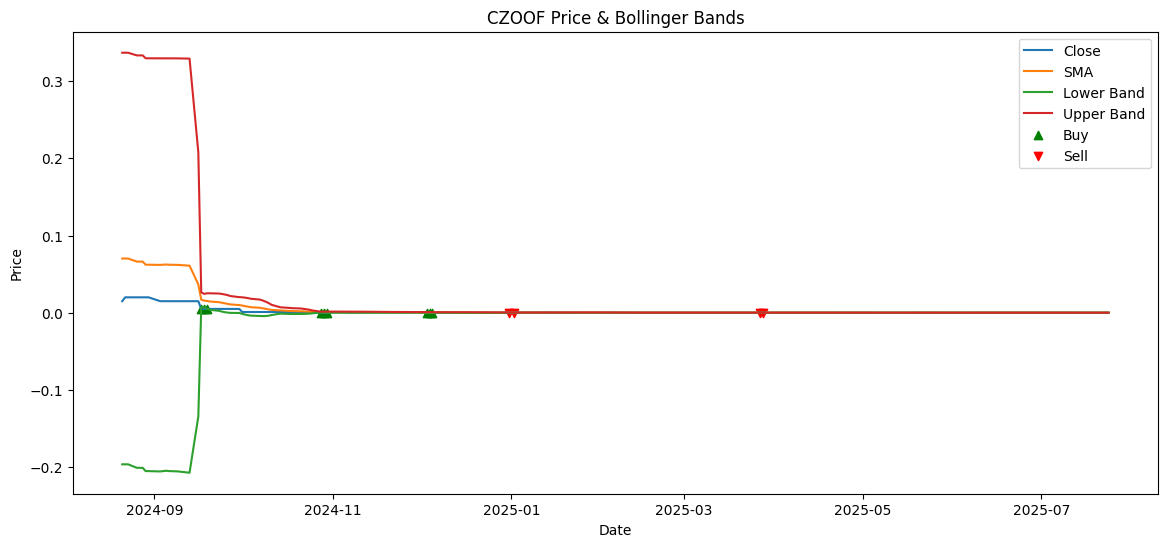

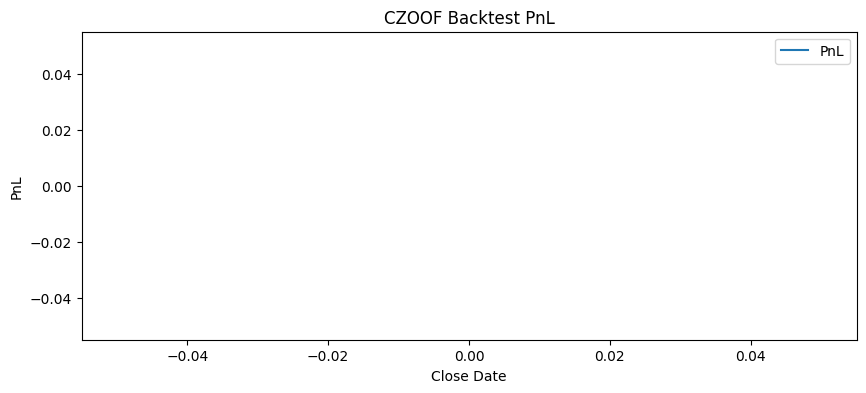


📈 Generating plots for FDIG...


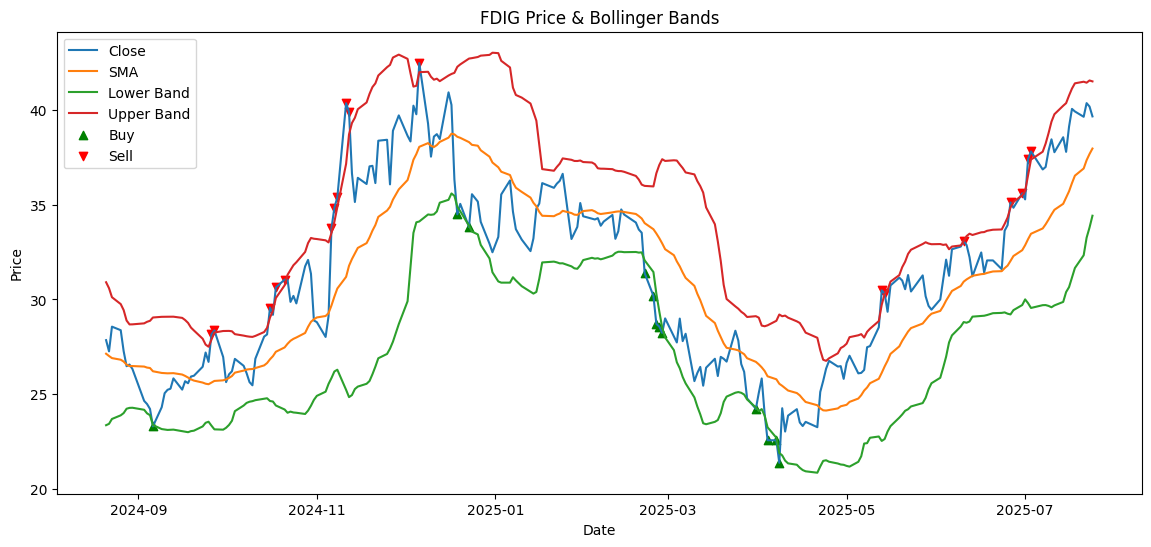

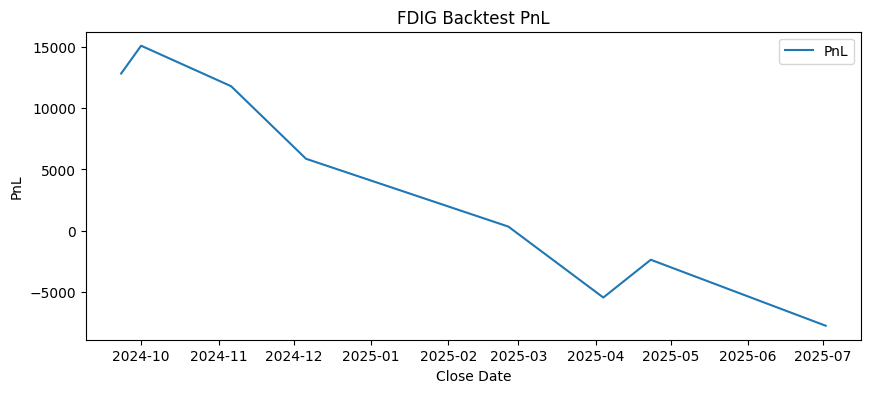


📈 Generating plots for LION...


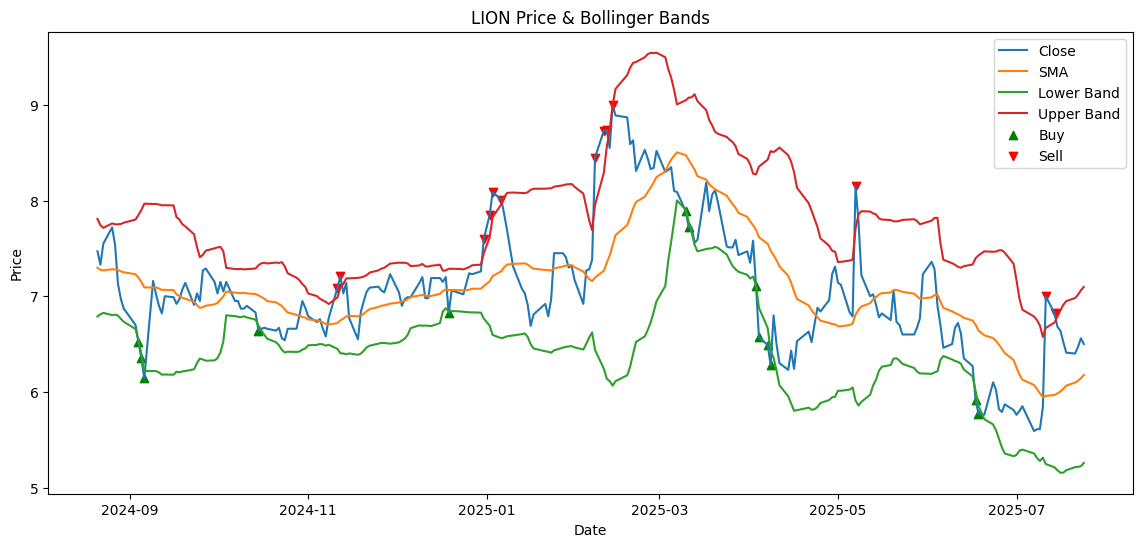

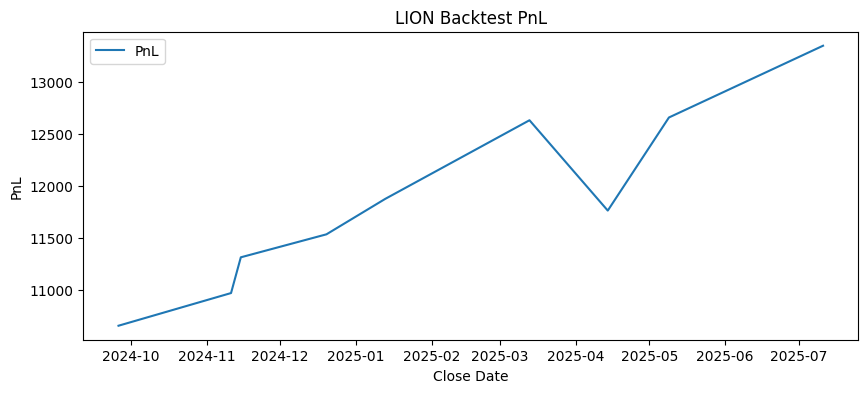


📈 Generating plots for OLLI...


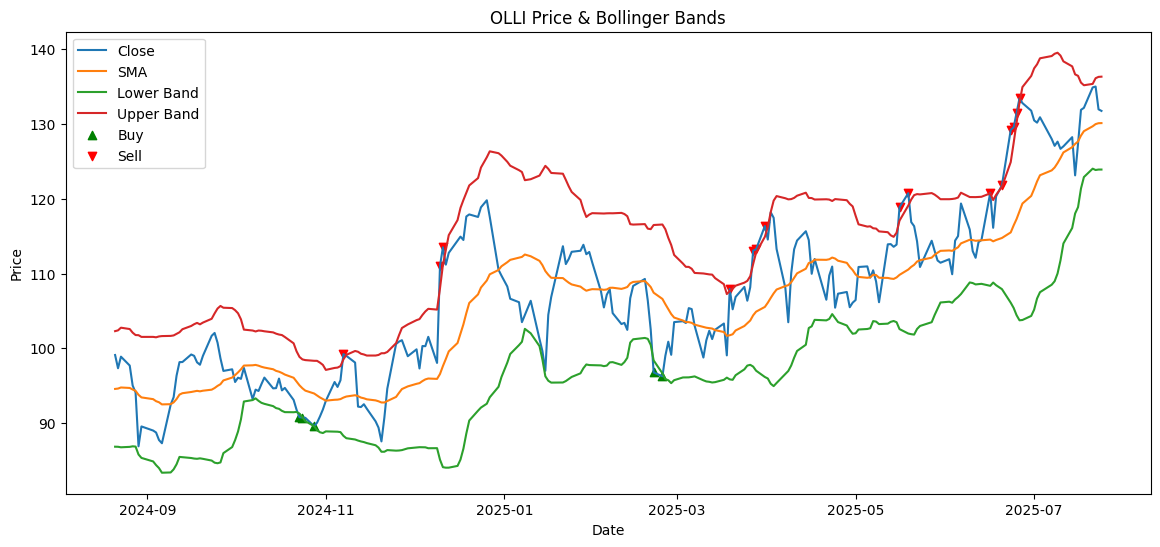

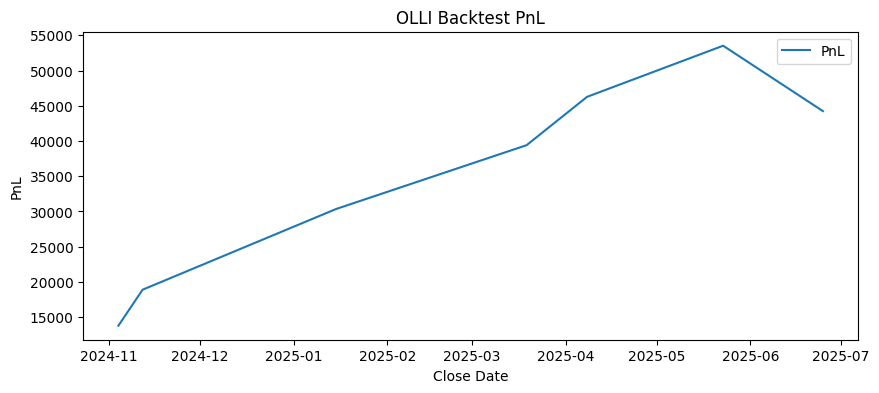


📈 Generating plots for UNP...


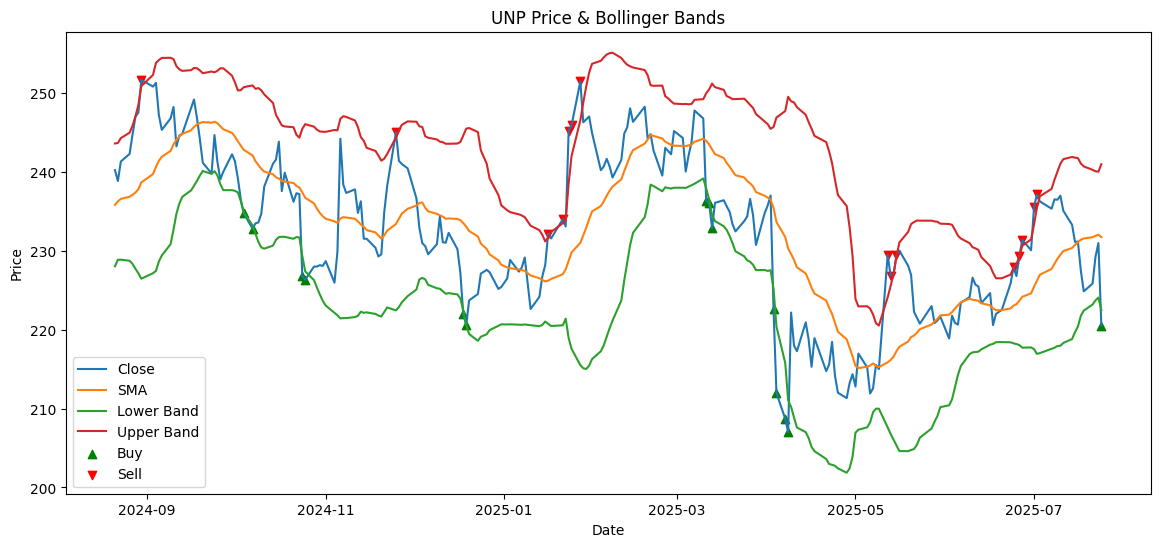

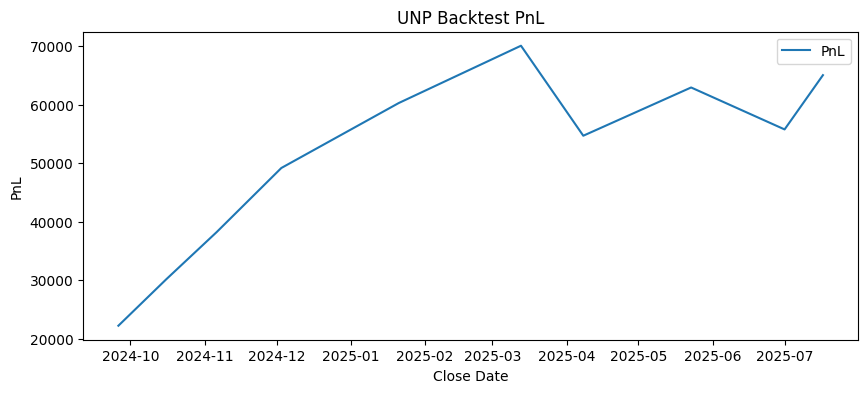


📈 Generating plots for VZ...


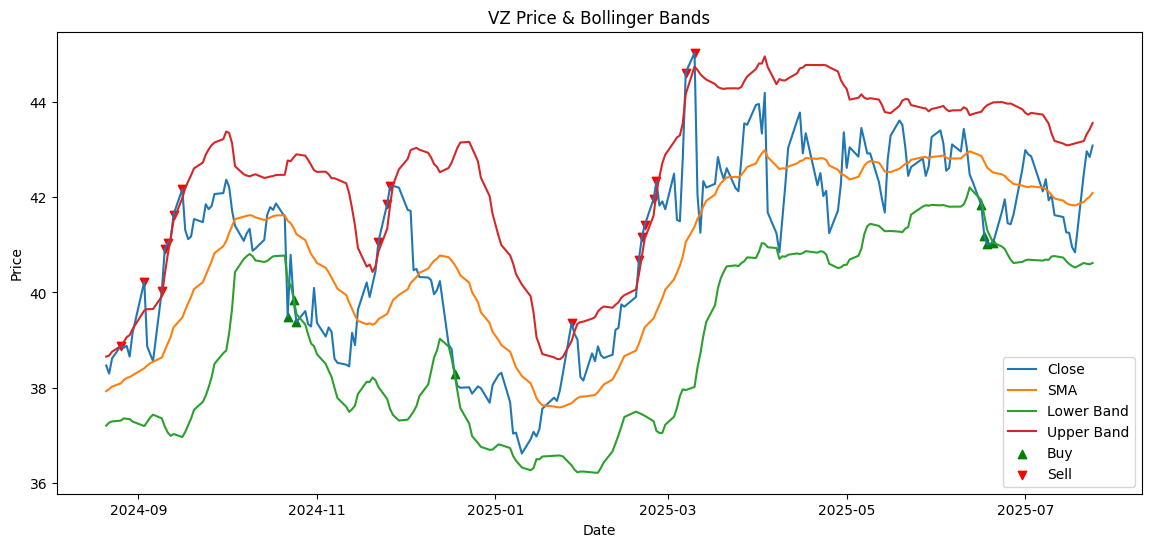

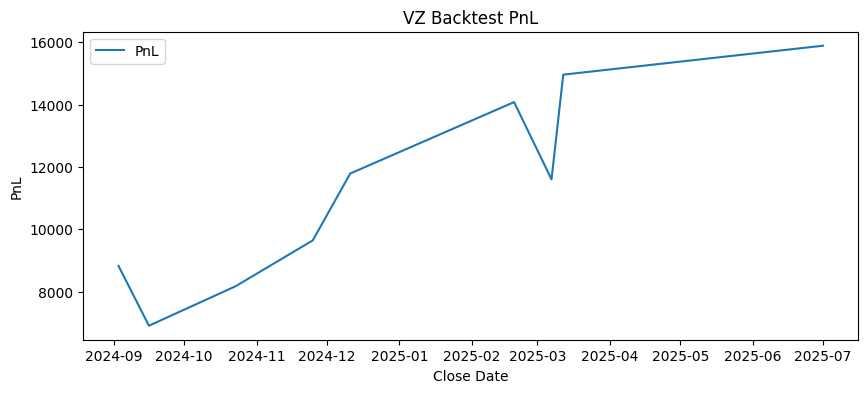


📈 Generating plots for WPP...


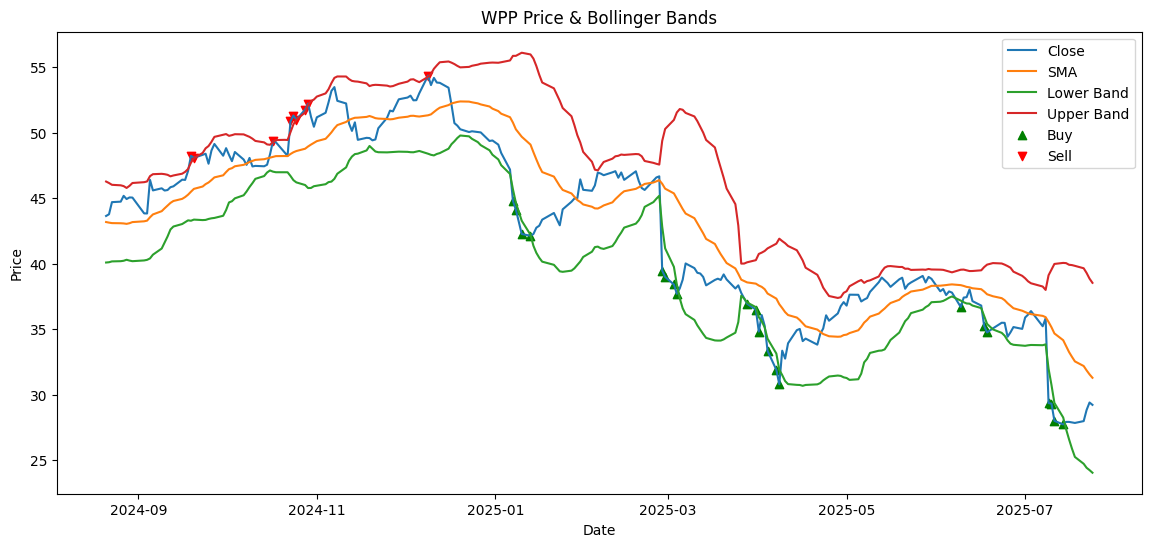

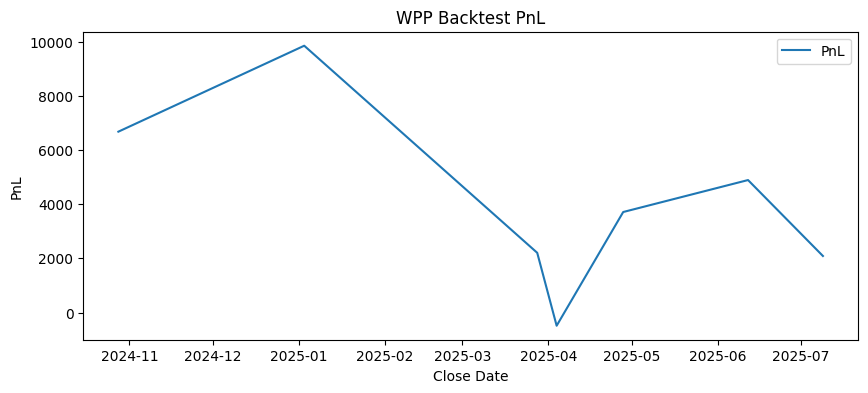

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

buy_signals = 0
sell_signals = 0
hold_signals = 0

for ticker_sym, forecast_data in portfolio_forecasts.items():
    print(f"\n📈 Generating plots for {ticker_sym.upper()}...")

    if 'error' in forecast_data:
        print(f"⚠️ Skipping {ticker_sym.upper()} due to error: {forecast_data['error']}")
        continue

    result = results.get(ticker_sym)
    if result is None or not isinstance(result, pd.DataFrame):
        print(f"⚠️ No backtest result for {ticker_sym.upper()}, skipping plot.")
        continue

    try:
        df = yf.download(ticker_sym, period="1y", interval="1d", progress=False)
        if df.empty or len(df) < 50:
            print(f"⚠️ Not enough price data for {ticker_sym.upper()}, skipping plot.")
            continue

        # Ensure columns are single-level and not MultiIndex
        df = df.copy()
        df['time'] = df.index
        df['sma'] = df['Close'].rolling(20).mean()
        df['sd'] = df['Close'].rolling(20).std()
        df['lb'] = df['sma'] - 2 * df['sd']
        df['ub'] = df['sma'] + 2 * df['sd']
        df.dropna(inplace=True)

        # Signal assignment (compare floats, not Series)
        def find_signal(row):
            close = float(row['Close'])
            lb = float(row['lb'])
            ub = float(row['ub'])
            if close < lb:
                return 'buy'
            elif close > ub:
                return 'sell'
            else:
                return 'hold'

        df['signal'] = df.apply(find_signal, axis=1)

    except Exception as e:
        print(f"⚠️ Error downloading or processing data for {ticker_sym.upper()}: {e}")
        continue

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['time'], df['Close'], label='Close')
    ax.plot(df['time'], df['sma'], label='SMA')
    ax.plot(df['time'], df['lb'], label='Lower Band')
    ax.plot(df['time'], df['ub'], label='Upper Band')

    buy_mask = df['signal'] == 'buy'
    sell_mask = df['signal'] == 'sell'
    ax.scatter(df['time'][buy_mask], df['Close'][buy_mask], label='Buy', color='green', marker='^')
    ax.scatter(df['time'][sell_mask], df['Close'][sell_mask], label='Sell', color='red', marker='v')

    ax.set_title(f"{ticker_sym.upper()} Price & Bollinger Bands")
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()

    if 'pnl' in result.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(result['close_datetime'], result['pnl'], label='PnL')
        plt.title(f"{ticker_sym.upper()} Backtest PnL")
        plt.xlabel('Close Date')
        plt.ylabel('PnL')
        plt.legend()
        plt.show()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

def plot_forecast_and_backtest(portfolio_forecasts, results):
    buy_signals = 0
    sell_signals = 0
    hold_signals = 0

    for ticker_sym, forecast_data in portfolio_forecasts.items():
        print(f"\n📈 Generating plots for {ticker_sym.upper()}...")

        if 'error' in forecast_data:
            print(f"⚠️ Skipping {ticker_sym.upper()} due to error: {forecast_data['error']}")
            continue

        result = results.get(ticker_sym)
        if result is None or not isinstance(result, pd.DataFrame):
            print(f"⚠️ No backtest result for {ticker_sym.upper()}, skipping plot.")
            continue

        try:
            df = yf.download(ticker_sym, period="1y", interval="1d", progress=False)
            if df.empty or len(df) < 50:
                print(f"⚠️ Not enough price data for {ticker_sym.upper()}, skipping plot.")
                continue

            df = df.copy()
            df['time'] = df.index
            df['sma'] = df['Close'].rolling(20).mean()
            df['sd'] = df['Close'].rolling(20).std()
            df['lb'] = df['sma'] - 2 * df['sd']
            df['ub'] = df['sma'] + 2 * df['sd']
            df.dropna(inplace=True)

            def find_signal(row):
                close = float(row['Close'])
                lb = float(row['lb'])
                ub = float(row['ub'])
                if close < lb:
                    return 'buy'
                elif close > ub:
                    return 'sell'
                else:
                    return 'hold'

            df['signal'] = df.apply(find_signal, axis=1)

        except Exception as e:
            print(f"⚠️ Error downloading or processing data for {ticker_sym.upper()}: {e}")
            continue

        # --- Price & Bollinger Bands Plot ---
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(df['time'], df['Close'], label='Close')
        ax.plot(df['time'], df['sma'], label='SMA')
        ax.plot(df['time'], df['lb'], label='Lower Band')
        ax.plot(df['time'], df['ub'], label='Upper Band')

        buy_mask = df['signal'] == 'buy'
        sell_mask = df['signal'] == 'sell'
        ax.scatter(df['time'][buy_mask], df['Close'][buy_mask], label='Buy', color='green', marker='^')
        ax.scatter(df['time'][sell_mask], df['Close'][sell_mask], label='Sell', color='red', marker='v')

        ax.set_title(f"{ticker_sym.upper()} Price & Bollinger Bands")
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        plt.show()

        # --- PnL Plot ---
        if 'pnl' in result.columns:
            plt.figure(figsize=(10, 4))
            plt.plot(result['close_datetime'], result['pnl'], label='PnL')
            plt.title(f"{ticker_sym.upper()} Backtest PnL")
            plt.xlabel('Close Date')
            plt.ylabel('PnL')
            plt.legend()
            plt.show()

    return



📈 Generating plots for CZOOF...


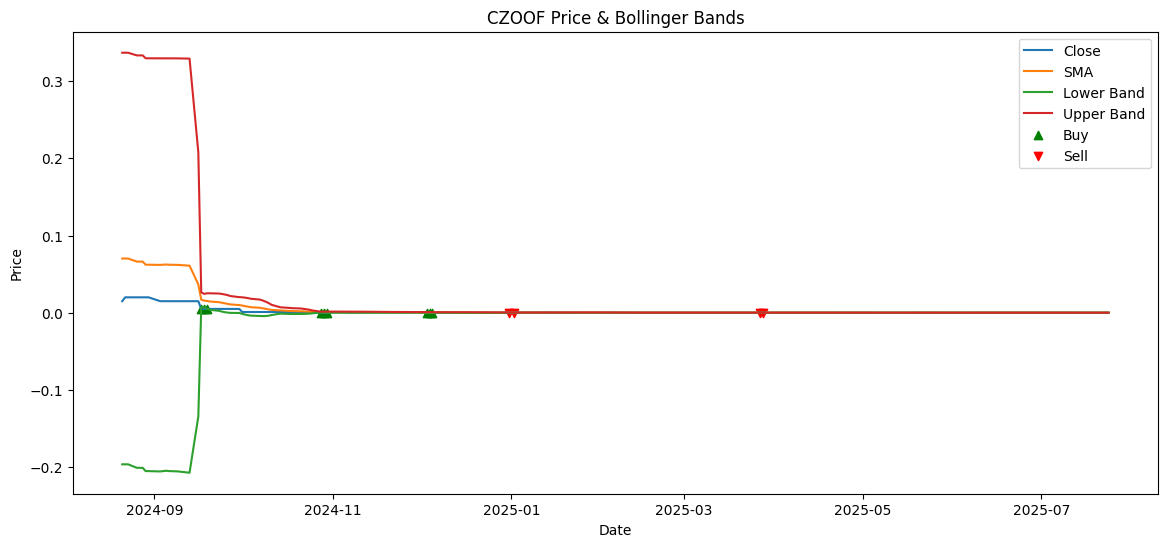

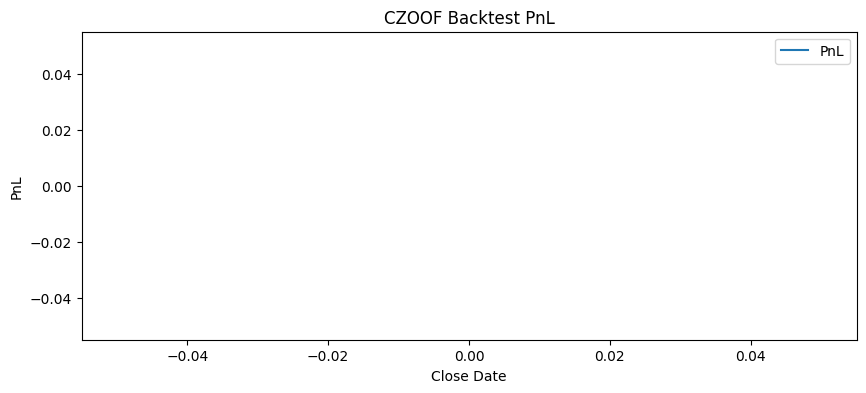


📈 Generating plots for FDIG...


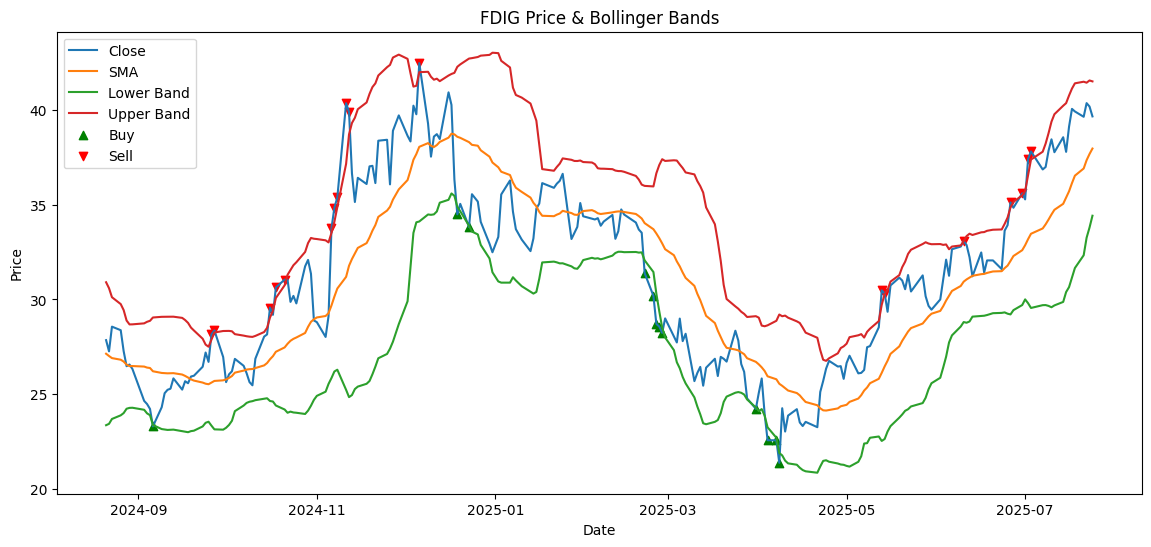

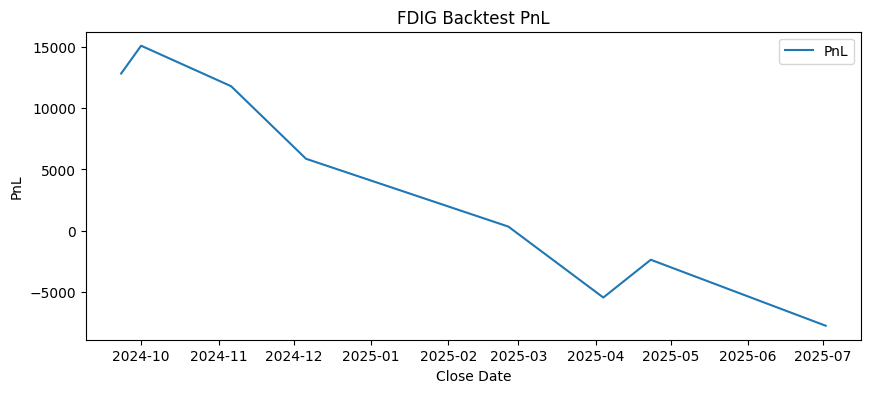


📈 Generating plots for LION...


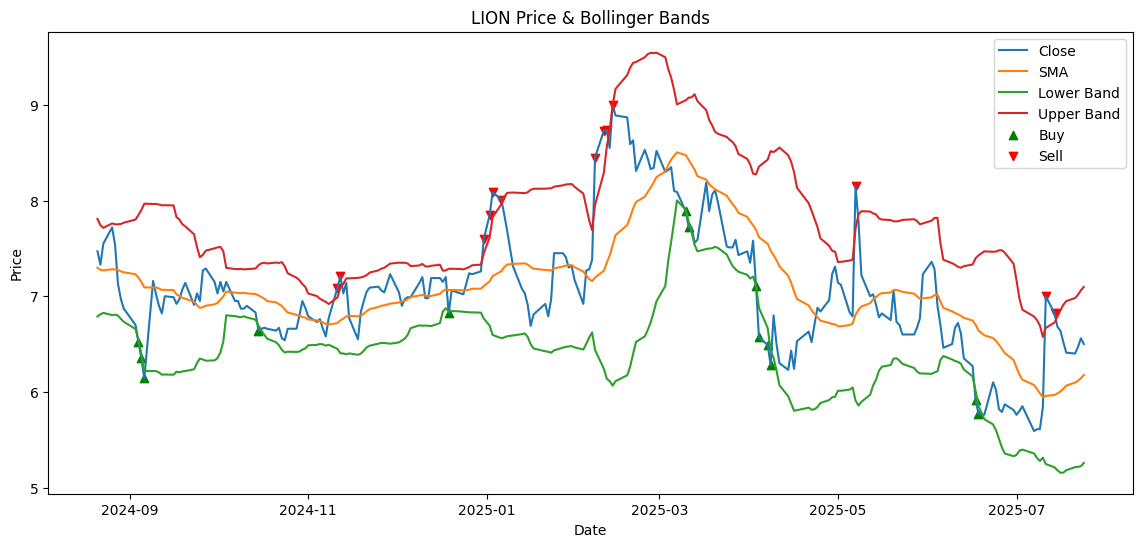

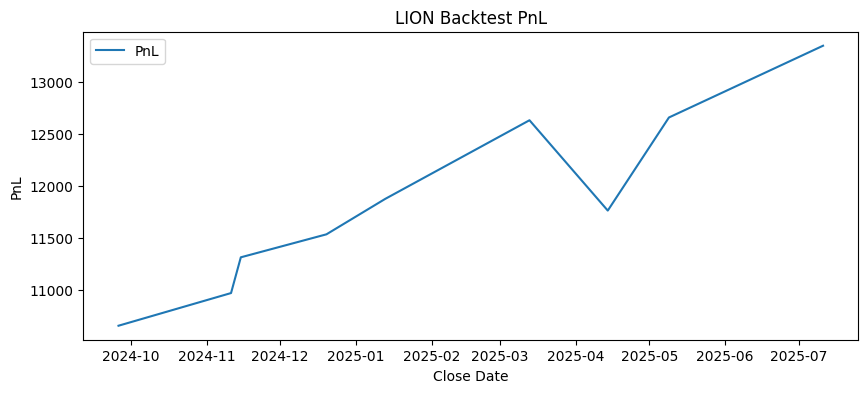


📈 Generating plots for OLLI...


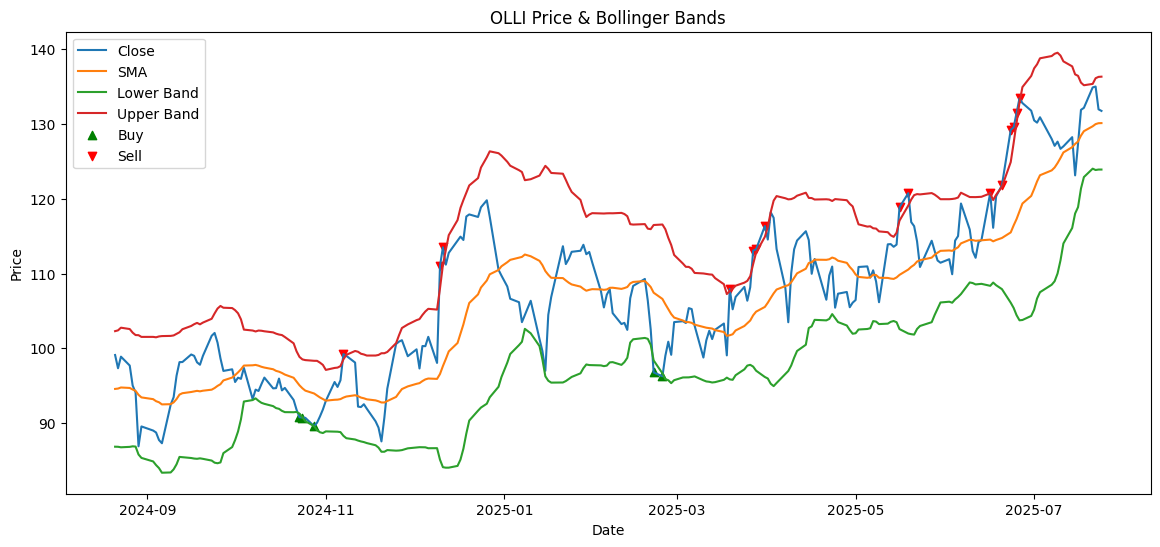

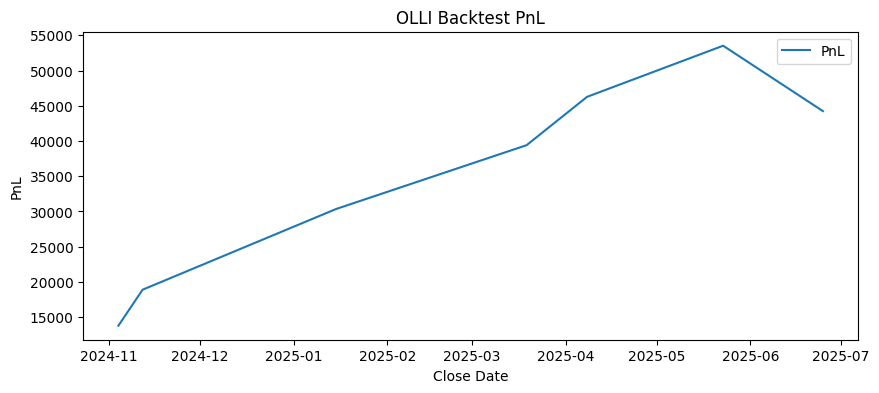


📈 Generating plots for UNP...


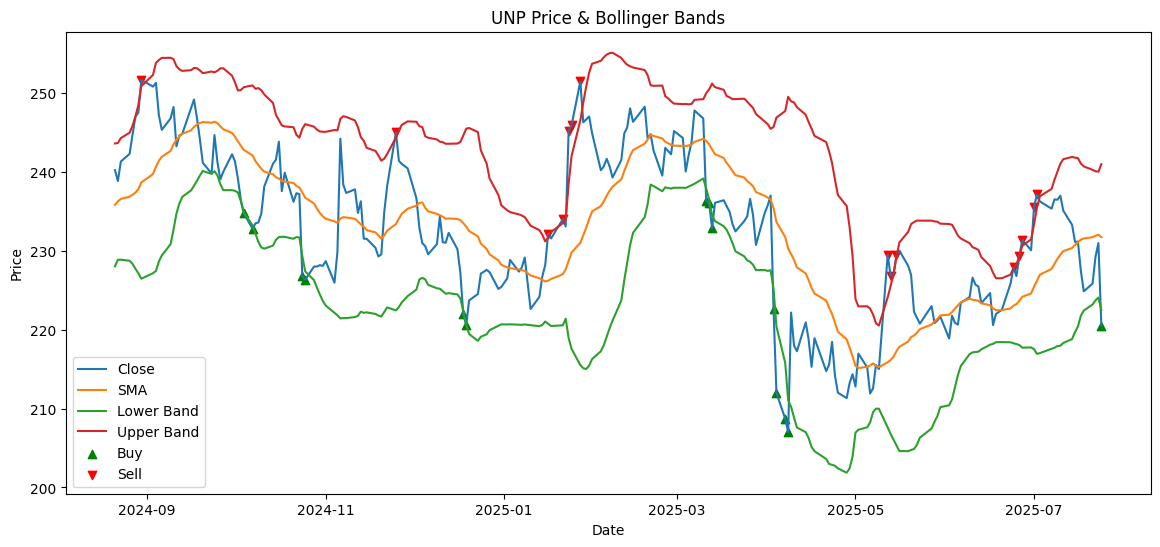

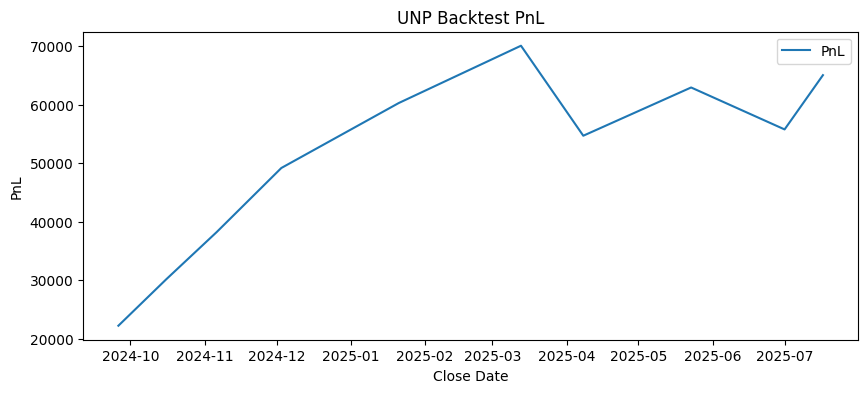


📈 Generating plots for VZ...


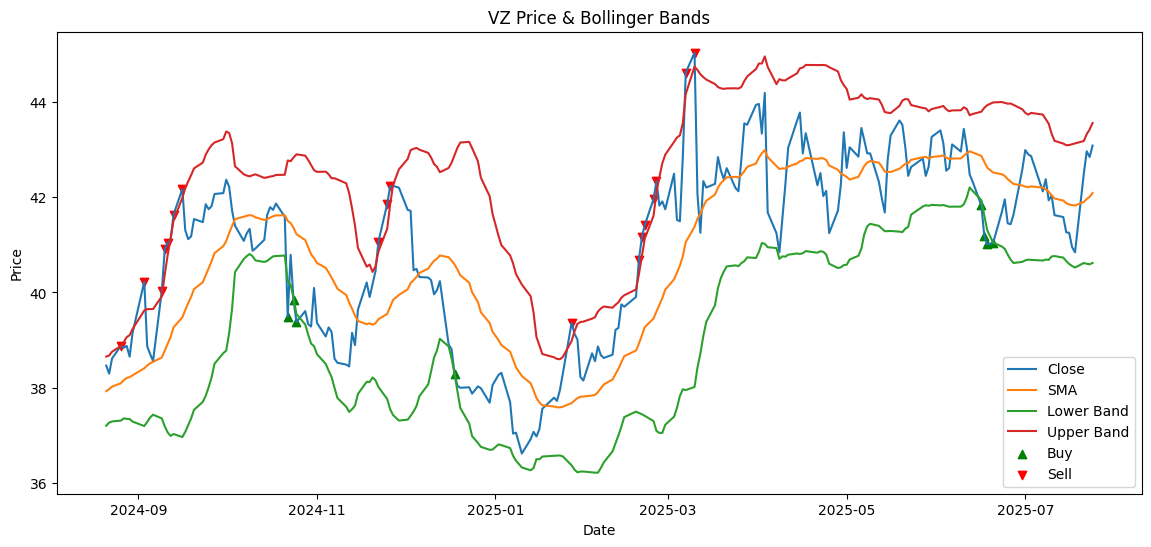

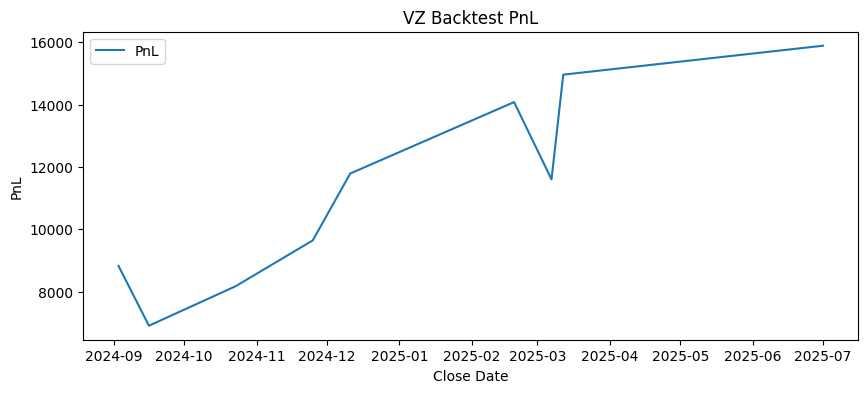


📈 Generating plots for WPP...


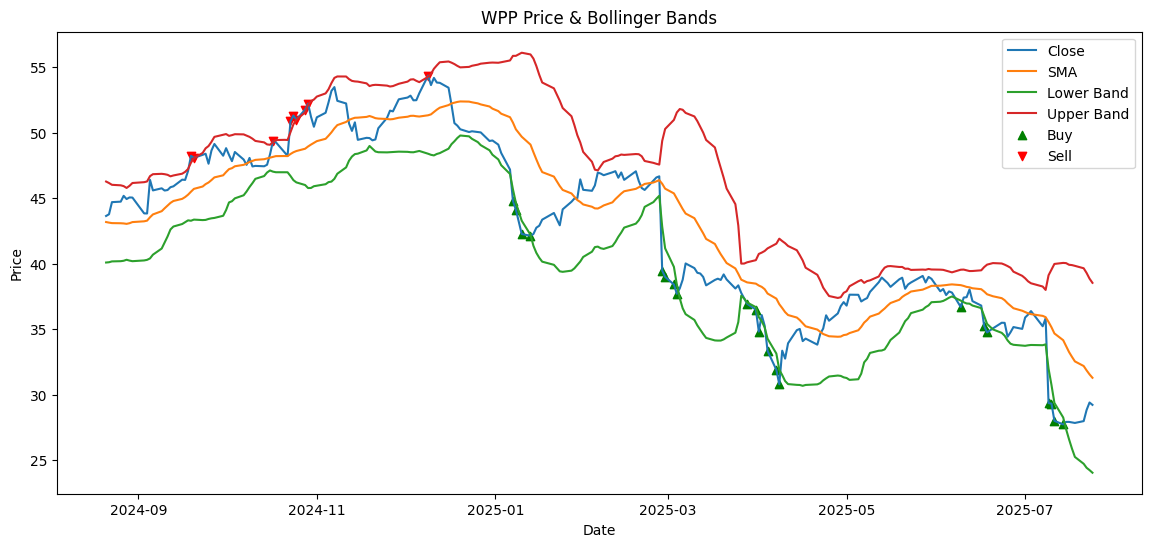

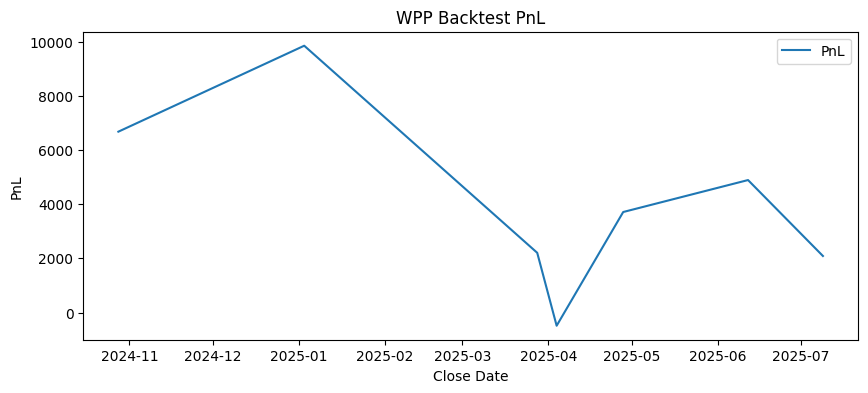

In [ ]:
# Use the plot_forecast_and_backtest function for all tickers in ticker_list
plot_forecast_and_backtest(portfolio_forecasts, results)